In [2]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import requests
from zipfile import ZipFile
import numpy as np
import shutil

# Step 1

def download_and_extract(zip_urls, download_folder, extract_folder):
    """
    Downloads ZIP files from provided URLs and extracts their contents.
    """
    os.makedirs(download_folder, exist_ok=True)
    os.makedirs(extract_folder, exist_ok=True)
    
    for idx, url in enumerate(zip_urls):
        print(f"({idx + 1}/{len(zip_urls)}) Downloading: {url}")
        zip_filename = os.path.join(download_folder, os.path.basename(url))
        
        # Download the file
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(zip_filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        print(f"Downloaded: {zip_filename}")
        
        # Extract the ZIP file
        with ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Extracted: {zip_filename} to {extract_folder}")

# Step 2

def process_large_csv(csv_files, temp_folder, chunk_size=100000):
    """Reads large CSV files and splits them into individual MMSI files efficiently."""
    os.makedirs(temp_folder, exist_ok=True)

    for csv_file in csv_files:
        print(f"Processing {csv_file}...")
        mmsi_file_handles = {}

        # Open file handles for each MMSI to append data directly to disk
        try:
            with tqdm(total=sum(1 for _ in open(csv_file)) - 1, desc="Processing chunks", unit="rows") as pbar:
                for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
                    # Filter out rows with 'Unknown value' in Navigational Status
                    chunk = chunk[chunk['Navigational status'] != 'Unknown value']

                    # Group by MMSI and write directly to files
                    for mmsi, group in chunk.groupby('MMSI'):
                        output_file = os.path.join(temp_folder, f"{mmsi}.csv")
                        if mmsi not in mmsi_file_handles:
                            # Open file in append mode if not already open
                            mmsi_file_handles[mmsi] = open(output_file, 'a', newline='')
                            # Write header if the file is new
                            group.to_csv(
                                mmsi_file_handles[mmsi],
                                index=False,
                                header=True,
                                mode='a'
                            )
                        else:
                            # Append without writing header
                            group.to_csv(
                                mmsi_file_handles[mmsi],
                                index=False,
                                header=False,
                                mode='a'
                            )

                    pbar.update(len(chunk))

        finally:
            # Ensure all file handles are closed
            for handle in mmsi_file_handles.values():
                handle.close()

    print("Processing complete.")

# step 2.2

def remove_duplicate_headers(folder, header_row=0):
    """
    Removes duplicate headers from all CSV files in a folder.

    Parameters:
        folder (str): Path to the folder containing the CSV files.
        header_row (int): Row number of the header (default is 0 for the first row).
    """
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            file_path = os.path.join(folder, file)
            # print(f"Processing {file_path}...")
            
            try:
                # Read the CSV file
                df = pd.read_csv(file_path, header=header_row)
                
                # Identify and remove rows matching the header
                header = list(df.columns)
                df = df[df.apply(lambda row: list(row) != header, axis=1)]
                
                # Write the cleaned data back to the file
                df.to_csv(file_path, index=False)
            
            except Exception as e:
                print(f"Error processing {file}: {e}")

    print("Duplicate headers removed.")

def filter_by_area(input_folder, output_folder, area_bounds):
    """Filters MMSI files for entries within a specified geographical area."""
    os.makedirs(output_folder, exist_ok=True)
    min_lat, max_lat, min_lon, max_lon = area_bounds

    for file in tqdm(os.listdir(input_folder), desc="Filtering by area"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        df = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat) & 
                (df['Longitude'] >= min_lon) & (df['Longitude'] <= max_lon)]
        if len(df) >= 10:  # Ensure at least 10 consecutive entries
            df.to_csv(os.path.join(output_folder, file), index=False)

def extract_time_sets(input_folder, output_folder, duration_minutes=30, tolerance_seconds=10):
    """Extracts time sets with consistent Navigational Status and saves each as a separate file with time range in the filename.
    Adds tolerance for duration of groups to account for small discrepancies (e.g., ±10 seconds).
    """
    os.makedirs(output_folder, exist_ok=True)

    for file in tqdm(os.listdir(input_folder), desc=f"Extracting {duration_minutes}-min sets"):
        if not file.endswith('.csv'):
            continue

        # Load the CSV file
        file_path = os.path.join(input_folder, file)
        try:
            df = pd.read_csv(file_path)

            # Strip leading and trailing spaces and remove the '#' from column names
            df.columns = df.columns.str.strip().str.lstrip('# ')
            print(f"Cleaned column names: {list(df.columns)}")

            # Ensure the 'Timestamp' column exists
            if 'Timestamp' not in df.columns:
                print(f"Error: 'Timestamp' column not found in {file}")
                continue

            # Convert the 'Timestamp' column to datetime
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
            except Exception as e:
                print(f"Error parsing 'Timestamp' in {file}: {e}")
                continue

            # Drop rows with invalid timestamps
            df = df.dropna(subset=['Timestamp'])

            # Skip files with only one entry
            if len(df) == 1:
                print(f"File '{file}' contains only one entry and will be skipped.")
                continue

            # Sort the DataFrame by timestamp
            df = df.sort_values('Timestamp')

            # Calculate the duration in minutes for each row and ensure it's consistent with the desired interval
            time_delta = pd.Timedelta(minutes=duration_minutes)

            # Calculate time groupings: we use the first timestamp to start the interval and group by durations
            df['Time_Group'] = ((df['Timestamp'] - df['Timestamp'].min()) // time_delta)

            grouped = df.groupby('Time_Group')

            valid_sets = 0
            for group_id, group in grouped:
                # Check if the Navigational Status is consistent
                if group['Navigational status'].nunique() == 1:
                    # Calculate the duration of the group
                    group_duration = group['Timestamp'].max() - group['Timestamp'].min()

                    # Calculate the expected duration in seconds
                    expected_duration_seconds = time_delta.total_seconds()

                    # Calculate the tolerance range (±10 seconds)
                    tolerance_range_min = expected_duration_seconds - tolerance_seconds
                    tolerance_range_max = expected_duration_seconds + tolerance_seconds
                    group_duration_seconds = group_duration.total_seconds()

                    # Skip groups that don't match the expected duration +/- tolerance
                    if not (tolerance_range_min <= group_duration_seconds <= tolerance_range_max):
                        print(f"File '{file}' has a group with a duration of {group_duration}. Skipping group {group_id}.")
                        continue

                    valid_sets += 1

                    # Get start and end times for the interval
                    start_time = group['Timestamp'].min().strftime('%Y%m%d_%H%M')
                    end_time = group['Timestamp'].max().strftime('%Y%m%d_%H%M')

                    # Construct the output filename with time range in the format: original_filename_starttime-endtime.csv
                    output_filename = f"{os.path.splitext(file)[0]}_{start_time}-{end_time}.csv"
                    output_path = os.path.join(output_folder, output_filename)

                    # Save the group as a separate file
                    group.to_csv(output_path, index=False)
                    print(f"Saved {duration_minutes}-min set: {output_filename}")

            if valid_sets == 0:
                print(f"No valid {duration_minutes}-min sets found in {file}.")

        except Exception as e:
            print(f"Error processing file {file}: {e}")

def analyze_navigational_status(input_folder):
    """Analyzes the distribution of 30-minute sets by Navigational Status."""
    status_counts = {}

    for file in tqdm(os.listdir(input_folder), desc="Analyzing Navigational Status"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        status = df['Navigational status'].iloc[0]  # Assuming consistent status in each set
        status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

def filter_and_save_csv(input_folder: str, output_folder: str, columns_to_keep: list, row_filter: str = None):
    """
    Processes CSV files in the input folder, keeps only the specified columns,
    optionally applies row filtering, removes duplicate rows based on "Timestamp",
    and saves the filtered CSV files to the output folder.

    Parameters:
    - input_folder (str): Path to the folder containing input .csv files.
    - output_folder (str): Path to the folder where the filtered .csv files will be saved.
    - columns_to_keep (list): List of column names to retain.
    - row_filter (str, optional): A string representing a row filter condition, 
                                  e.g., 'SOG > 0'. Defaults to None (no row filtering).
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # List all the CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(input_folder, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Remove duplicate rows based on the "Timestamp" column
        df = df.drop_duplicates(subset=["Timestamp"], keep="first")
        
        # Filter only the columns you need
        df_filtered = df[columns_to_keep]
        
        # Apply the row filtering condition if provided
        if row_filter:
            df_filtered = df_filtered.query(row_filter)
        
        # Save the filtered DataFrame to the output folder
        output_path = os.path.join(output_folder, f'filtered_{file}')
        df_filtered.to_csv(output_path, index=False)
        
        print(f"Processed {file} and saved to {output_path}")

def check_missing_values_in_csv(directory_path):
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in each column
            missing_data = df.isnull().sum()
            
            print(f"Missing values in {filename}:")
            print(missing_data)
            
            # Handle missing values:
            for column in df.columns:
                if missing_data[column] > 0:
                    # Suggestion for handling missing values
                    print(f"\nColumn: {column}")
                    if df[column].dtype in ['float64', 'int64']:
                        # Numeric columns: Suggest filling or interpolating
                        print(f"Suggested action: Interpolate missing values or fill with a default value (e.g., 0).")
                    else:
                        # Non-numeric columns (e.g., text): Suggest filling with the mode or dropping rows
                        print(f"Suggested action: Fill missing values with the most frequent value or drop rows.")
            
            print("\n")

def process_csv_files(input_folder):
    """
    Processes CSV files in a given folder to handle missing numerical values.

    Parameters:
    input_folder (str): Path to the folder containing CSV files.

    Returns:
    dict: A dictionary with statistics about the processing.
    """
    # Counters for statistics
    files_deleted = 0
    files_with_interpolation = 0

    # Function to process a single CSV file
    def process_csv(file_path):
        nonlocal files_deleted, files_with_interpolation

        try:
            # Read the CSV file
            df = pd.read_csv(file_path, parse_dates=['Timestamp'])

            # Ensure numerical columns only
            numerical_columns = ['Latitude', 'Longitude', 'SOG', 'COG', 'Heading']
            for col in numerical_columns:
                if col not in df.columns:
                    raise ValueError(f"Missing expected column: {col}")

            # Check for columns with all missing values
            for col in numerical_columns:
                if df[col].isnull().all():
                    print(f"File {file_path} has an entire column '{col}' with missing values. Deleting file.")
                    os.remove(file_path)
                    files_deleted += 1
                    return

            # Calculate missing values per row in numerical columns
            df['missing_values_count'] = df[numerical_columns].isnull().sum(axis=1)

            # Check for rows with more than 50% missing numerical values
            if (df['missing_values_count'] > len(numerical_columns) / 2).any():
                print(f"File {file_path} has rows with >50% missing values. Deleting file.")
                os.remove(file_path)
                files_deleted += 1
                return

            # Check if any interpolation is needed
            if df[numerical_columns].isnull().any().any():
                print(f"File {file_path} requires interpolation.")
                files_with_interpolation += 1

            # Ensure Timestamp column is properly parsed and set as the index
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')

            # Interpolate missing values based on the timestamp
            df[numerical_columns] = df[numerical_columns].interpolate(
                method='time', limit_direction='both', axis=0
            )

            # Reset the index after interpolation
            df = df.reset_index()

            # Drop the helper column
            df = df.drop(columns=['missing_values_count'])

            # Overwrite the original file
            df.to_csv(file_path, index=False)
            print(f"File {file_path} has been updated.")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Iterate over all files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            process_csv(file_path)

    # Final check for missing values in all processed files
    missing_values_found = False
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            df = pd.read_csv(file_path)
            if df.isnull().any().any():
                print(f"File {file_path} still contains missing values!")
                missing_values_found = True

    if not missing_values_found:
        print("No missing values found in any processed files.")

    # Return statistics
    return {
        "files_deleted": files_deleted,
        "files_with_interpolation": files_with_interpolation,
        "missing_values_remaining": missing_values_found
    }

# Function to standardize the time intervals in each CSV file
def standardize_time_intervals(file_path, interval_seconds=10, output_folder="standardized_files"):
    # Step 1: Read the CSV file
    df = pd.read_csv(file_path)
    
    # Step 2: Convert the 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Step 3: Generate a regular time range starting from the first timestamp to the last
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    # Create a new time index with the specified interval (e.g., every 10 seconds)
    new_time_index = pd.date_range(start=start_time, end=end_time, freq=f'{interval_seconds}s')
    
    # Step 4: Interpolate the data for each numerical column
    df.set_index('Timestamp', inplace=True)
    
    # Reindex the dataframe to the new time index and interpolate missing numerical values
    df_resampled = df.reindex(new_time_index)

    # Interpolate only numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    df_resampled[numerical_columns] = df_resampled[numerical_columns].interpolate(method='linear')

    # For non-numerical columns (like 'Navigational Status'), we fill the missing values by forward filling (ffill)
    df_resampled['Navigational status'] = df_resampled['Navigational status'].ffill()

    # Reset index to have Timestamp as a column again
    df_resampled.reset_index(inplace=True)
    df_resampled.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    # Step 5: Ensure output folder exists, create if it doesn't
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Generate the output file path
    output_path = os.path.join(output_folder, file_path.split(os.sep)[-1].replace('.csv', f'_standardized_{interval_seconds}s.csv'))
    
    # Step 6: Save the result to a new CSV file in the output folder
    df_resampled.to_csv(output_path, index=False)
    print(f"Standardized file saved to {output_path}")

# Step 11: Function to process each CSV file
def process_csv_step11(file_path, output_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Remove the specified columns
    columns_to_remove = ['MMSI', 'Latitude', 'Longitude']
    df = df.drop(columns=columns_to_remove, errors='ignore')
    
    # Check if 'COG' and 'Heading' columns exist and subtract the first value of 'COG' from both columns
    if 'COG' in df.columns and 'Heading' in df.columns:
        first_cog = df['COG'].iloc[0]
        
        # Subtract the first 'COG' value from all 'COG' and 'Heading' values, ensuring the 0-360 format
        def adjust_angle(x, first_cog_value):
            diff = x - first_cog_value
            return (diff + 360) % 360
    
        df['COG'] = df['COG'].apply(lambda x: adjust_angle(x, first_cog))
        df['Heading'] = df['Heading'].apply(lambda x: adjust_angle(x, first_cog))
          
    # Save the modified DataFrame to the new folder
    df.to_csv(output_path, index=False)
    # print(f"Processed file saved to: {output_path}")

# Step 12: Speed threshold
def check_and_move_files(folder_1, folder_2, dest_folder_1, dest_folder_2, sog_threshold_fishing, sog_threshold_underway):
    # Ensure the destination folders exist, create them if not
    os.makedirs(dest_folder_1, exist_ok=True)
    os.makedirs(dest_folder_2, exist_ok=True)

    # Step 1: Get all CSV files in the two specified folders
    csv_files_1 = [f for f in os.listdir(folder_1) if f.endswith('.csv')]
    csv_files_2 = [f for f in os.listdir(folder_2) if f.endswith('.csv')]

    # Function to check conditions and move files for a given folder
    def process_files_in_folder(folder, dest_folder, sog_threshold_fishing, sog_threshold_underway):
        for csv_file in os.listdir(folder):
            if csv_file.endswith('.csv'):
                file_path = os.path.join(folder, csv_file)
                try:
                    df = pd.read_csv(file_path)

                    # Case 1: Check for "Engaged in fishing" and mean SOG > sog_threshold_fishing
                    fishing_condition = (df['Navigational status'] == 'Engaged in fishing')
                    mean_sog = df['SOG'].mean()
                    
                    # Case 2: Check for "Underway using engine" and any SOG > sog_threshold_underway
                    underway_condition = (df['Navigational status'] == 'Underway using engine')
                    sog_above_threshold = df['SOG'] > sog_threshold_underway
                    
                    # If any condition is met, move the file
                    if (fishing_condition.any() and mean_sog > sog_threshold_fishing) or \
                       (underway_condition.any() and sog_above_threshold.any()):
                        shutil.move(file_path, os.path.join(dest_folder, csv_file))
                        print(f"Moved {csv_file} from {folder} to {dest_folder}")

                except Exception as e:
                    print(f"Failed to process {csv_file} in {folder}: {e}")

    # Process files in both folders
    process_files_in_folder(folder_1, dest_folder_1, sog_threshold_fishing, sog_threshold_underway)
    process_files_in_folder(folder_2, dest_folder_2, sog_threshold_fishing, sog_threshold_underway)

def integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds):
    """
    Downloads and processes ZIP files, extracting CSVs and running the pipeline.
    """
    """# Step 1: Download and Extract
    # download_folder = './downloaded_zips'"""
    extract_folder = './extracted_files'    
    # download_and_extract(zip_urls, download_folder, extract_folder)

    # Step 2: Split CSVs into MMSI-specific files
    process_large_csv([os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.csv')], temp_folder)

    # Step 2.2
    folder_path = "mmsi_temp"
    remove_duplicate_headers(folder_path)

    # Step 3: Filter files by geographical area
    filtered_folder = './filtered_area'
    filter_by_area(temp_folder, filtered_folder, area_bounds)

    # Step 4: Extract time sets
    extract_time_sets(input_folder='./filtered_area', output_folder='./time_sets', duration_minutes=120, tolerance_seconds=30)

    # Step 5: Analyze Navigational Status
    sets_folder = './time_sets'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 6: Slim the .csv files down to what we want to work with
    input_folder = './time_sets'
    output_folder = './time_sets_slim'

    # Columns you want to retain in the filtered CSVs
    columns_to_keep = [
        'Timestamp', 'MMSI', 'Latitude', 'Longitude', 
        'Navigational status', 'SOG', 'COG', 'Heading'
    ]

    # Optionally define a row filter (e.g., remove rows with SOG <= 0)
    # row_filter = 'SOG > 0'  # Optional, can be set to None if no filtering is needed

    # Call the function
    filter_and_save_csv(input_folder, output_folder, columns_to_keep)

    # Step 7: Getting overview of missing values in the slimmed sets
    directory_path = "./time_sets_slim"
    check_missing_values_in_csv(directory_path)

    # Step 8: Imputing and deleting
    input_folder = "./time_sets_slim"
    process_csv_files(input_folder)

    # Step 9: Analyze Navigational Status again
    sets_folder = './time_sets_slim'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 10: standardize to specified interval in files
    folder_path = 'time_sets_slim'
    output_folder = 'time_sets_standardized'

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            standardize_time_intervals(file_path, interval_seconds=60, output_folder=output_folder)  # Adjust interval as needed
    
    # Step 11: cut down to what we would have in radar and zeroed course
    # Define the input and output folders
    input_folder = 'time_sets_standardized'  # Replace with your folder containing CSV files
    output_folder = 'time_sets_st_shortened'
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through all CSV files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.csv'):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, filename)
            
            # Process each CSV file
            process_csv_step11(input_file, output_file)
    
    # Step 12: Speed thresholds
    folder_1 = 'time_sets_standardized'
    folder_2 = 'time_sets_st_shortened'
    dest_folder_1 = 'time_sets_standardized_out'
    dest_folder_2 = 'time_sets_st_shortened_out'

    sog_threshold_fishing = 10.0  # Example threshold for "Engaged in fishing" scenario
    sog_threshold_underway = 30.0  # Example threshold for "Underway using engine" scenario

    check_and_move_files(folder_1, folder_2, dest_folder_1, dest_folder_2, sog_threshold_fishing, sog_threshold_underway)
    


# Example URLs for ZIP files (replace with actual URLs)
zip_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-05-24.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-23.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-22.zip"
]

# Example usage
area_bounds = (55.0, 56.0, 7.0, 8.0)  # Define your area
temp_folder = './mmsi_temp'
integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds)


Processing ./extracted_files\aisdk-2024-04-01.csv...


Processing chunks:  82%|████████▏ | 12862759/15689756 [04:27<00:58, 48144.32rows/s]


Processing ./extracted_files\aisdk-2024-04-02.csv...


Processing chunks:  83%|████████▎ | 9271275/11160673 [03:06<00:38, 49636.49rows/s]


Processing ./extracted_files\aisdk-2024-04-03.csv...


Processing chunks:  84%|████████▍ | 11939428/14220360 [04:00<00:45, 49736.58rows/s]


Processing ./extracted_files\aisdk-2024-04-04.csv...


Processing chunks:  84%|████████▍ | 12906910/15371432 [04:20<00:49, 49497.84rows/s]


Processing ./extracted_files\aisdk-2024-04-05.csv...


Processing chunks:  83%|████████▎ | 12374891/14857850 [04:11<00:50, 49282.60rows/s]


Processing ./extracted_files\aisdk-2024-04-06.csv...


Processing chunks:  83%|████████▎ | 12825916/15536257 [04:27<00:56, 48022.08rows/s]


Processing ./extracted_files\aisdk-2024-04-07.csv...


Processing chunks:  84%|████████▍ | 14129058/16865774 [04:47<00:55, 49111.06rows/s]


Processing ./extracted_files\aisdk-2024-04-08.csv...


Processing chunks:  83%|████████▎ | 13704577/16536796 [04:38<00:57, 49143.14rows/s]


Processing ./extracted_files\aisdk-2024-04-09.csv...


Processing chunks:  83%|████████▎ | 13670536/16519806 [04:42<00:58, 48330.14rows/s]


Processing ./extracted_files\aisdk-2024-04-10.csv...


Processing chunks:  83%|████████▎ | 13025685/15614771 [04:18<00:51, 50320.66rows/s]


Processing ./extracted_files\aisdk-2024-04-11.csv...


Processing chunks:  84%|████████▍ | 13119087/15662943 [04:20<00:50, 50385.52rows/s]


Processing ./extracted_files\aisdk-2024-04-12.csv...


Processing chunks:  83%|████████▎ | 12806076/15446313 [04:16<00:52, 49990.47rows/s]


Processing ./extracted_files\aisdk-2024-04-13.csv...


Processing chunks:  83%|████████▎ | 13754872/16497947 [04:42<00:56, 48689.49rows/s]


Processing ./extracted_files\aisdk-2024-04-14.csv...


Processing chunks:  84%|████████▎ | 13122735/15715739 [04:18<00:51, 50803.64rows/s]


Processing ./extracted_files\aisdk-2024-04-15.csv...


Processing chunks:  83%|████████▎ | 13234138/15970651 [04:27<00:55, 49541.16rows/s]


Processing ./extracted_files\aisdk-2024-04-16.csv...


Processing chunks:  83%|████████▎ | 14545144/17468321 [04:52<00:58, 49729.04rows/s]


Processing ./extracted_files\aisdk-2024-04-17.csv...


Processing chunks:  82%|████████▏ | 14389371/17586357 [04:52<01:05, 49123.66rows/s]


Processing ./extracted_files\aisdk-2024-04-18.csv...


Processing chunks:  82%|████████▏ | 13950636/16973019 [04:41<01:01, 49489.47rows/s]


Processing ./extracted_files\aisdk-2024-04-19.csv...


Processing chunks:  82%|████████▏ | 13643917/16550076 [04:33<00:58, 49827.34rows/s]


Processing ./extracted_files\aisdk-2024-04-20.csv...


Processing chunks:  81%|████████▏ | 13132300/16160193 [04:23<01:00, 49745.60rows/s]


Processing ./extracted_files\aisdk-2024-04-21.csv...


Processing chunks:  81%|████████  | 12560282/15579541 [04:12<01:00, 49785.72rows/s]


Processing ./extracted_files\aisdk-2024-04-22.csv...


Processing chunks:  82%|████████▏ | 12507972/15278392 [04:09<00:55, 50167.97rows/s]


Processing ./extracted_files\aisdk-2024-04-23.csv...


Processing chunks:  82%|████████▏ | 13274921/16213210 [04:27<00:59, 49690.09rows/s]


Processing ./extracted_files\aisdk-2024-04-24.csv...


Processing chunks:  82%|████████▏ | 13577224/16616961 [04:37<01:02, 48993.70rows/s]


Processing ./extracted_files\aisdk-2024-04-25.csv...


Processing chunks:  82%|████████▏ | 14016244/17086455 [04:46<01:02, 48896.31rows/s]


Processing ./extracted_files\aisdk-2024-04-26.csv...


Processing chunks:  82%|████████▏ | 13948185/16941754 [04:42<01:00, 49403.13rows/s]


Processing ./extracted_files\aisdk-2024-04-27.csv...


Processing chunks:  81%|████████  | 15217550/18776989 [05:16<01:13, 48112.38rows/s]


Processing ./extracted_files\aisdk-2024-04-28.csv...


Processing chunks:  82%|████████▏ | 16084487/19727874 [05:38<01:16, 47471.89rows/s]


Processing ./extracted_files\aisdk-2024-04-29.csv...


Processing chunks:  81%|████████  | 14803087/18230506 [05:08<01:11, 48017.56rows/s]


Processing ./extracted_files\aisdk-2024-04-30.csv...


Processing chunks:  82%|████████▏ | 16719287/20278811 [05:53<01:15, 47333.63rows/s]


Processing complete.


C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,11,12,14,15,16,18,20,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=header_row)
C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,11,12,14,15,16,18,20,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=header_row)
C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,14,15,16,18,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=header_row)
C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,10,15,16,18,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(

Duplicate headers removed.


Filtering by area:   0%|          | 0/6505 [00:00<?, ?it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:124: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   0%|          | 3/6505 [00:00<09:43, 11.14it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:124: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:124: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   0%|          | 8/6505 [00:03<53:26,  2.03it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:124: DtypeWarning: Columns (12) have mixed types. Specify dtype option on i

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '111219508.csv' has a group with a duration of 0 days 00:33:16. Skipping group 0.
No valid 120-min sets found in 111219508.csv.


Extracting 120-min sets:   1%|          | 4/488 [00:00<00:48, 10.01it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '205159000.csv' has a group with a duration of 0 days 01:41:10. Skipping group 1.
No valid 120-min sets found in 205159000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '205538000.csv' has a group with a duration of 0 days 01:12:11. Skipping group 0.
No valid 120-min sets found in 205538000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Na

Extracting 120-min sets:   1%|          | 6/488 [00:00<00:52,  9.19it/s]

Saved 120-min set: 209207000_20240407_2238-20240408_0038.csv
Saved 120-min set: 209207000_20240408_0038-20240408_0238.csv
File '209207000.csv' has a group with a duration of 0 days 01:37:59. Skipping group 2.
File '209207000.csv' has a group with a duration of 0 days 01:12:19. Skipping group 250.
File '209207000.csv' has a group with a duration of 0 days 00:04:40. Skipping group 251.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 209318000_20240424_1055-20240424_1255.csv
File '209318000.csv' has a group with a duration of 0 days 01:46:08. Skipping group 1.
File '209318000.csv' has a group with a duration of 0 days 00:58:49. Skipping group 12.
File '209318000.csv' has a group with a duration of 0 d

Extracting 120-min sets:   2%|▏         | 8/488 [00:01<01:20,  5.99it/s]

Saved 120-min set: 209525000_20240423_1931-20240423_2130.csv
File '209525000.csv' has a group with a duration of 0 days 01:28:21. Skipping group 90.
File '209525000.csv' has a group with a duration of 0 days 00:19:29. Skipping group 173.
File '209525000.csv' has a group with a duration of 0 days 00:57:08. Skipping group 174.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:   2%|▏         | 9/488 [00:01<01:40,  4.75it/s]

Saved 120-min set: 209541000_20240405_1932-20240405_2132.csv
File '209541000.csv' has a group with a duration of 0 days 01:30:42. Skipping group 1.
File '209541000.csv' has a group with a duration of 0 days 01:34:25. Skipping group 31.
File '209541000.csv' has a group with a duration of 0 days 01:59:21. Skipping group 32.
Saved 120-min set: 209541000_20240408_1332-20240408_1532.csv
File '209541000.csv' has a group with a duration of 0 days 00:37:20. Skipping group 34.
File '209541000.csv' has a group with a duration of 0 days 01:34:10. Skipping group 68.
File '209541000.csv' has a group with a duration of 0 days 01:19:31. Skipping group 69.
File '209541000.csv' has a group with a duration of 0 days 00:34:00. Skipping group 153.
Saved 120-min set: 209541000_20240418_1532-20240418_1732.csv
File '209541000.csv' has a group with a duration of 0 days 01:07:36. Skipping group 155.
File '209541000.csv' has a group with a duration of 0 days 01:16:19. Skipping group 192.
File '209541000.csv' ha

Extracting 120-min sets:   2%|▏         | 11/488 [00:01<01:28,  5.38it/s]

Saved 120-min set: 209715000_20240404_0141-20240404_0341.csv
Saved 120-min set: 209715000_20240404_0341-20240404_0541.csv
File '209715000.csv' has a group with a duration of 0 days 00:28:20. Skipping group 2.
File '209715000.csv' has a group with a duration of 0 days 00:55:00. Skipping group 161.
Saved 120-min set: 209715000_20240417_1341-20240417_1541.csv
Saved 120-min set: 209715000_20240417_1541-20240417_1741.csv
File '209715000.csv' has a group with a duration of 0 days 00:21:10. Skipping group 164.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '210046000.csv' has a group with a duration of 0 days 01:04:39. Skipping group 0.
No valid 120-min sets found in 210046000.csv.
Cleaned column names: ['Timestamp', 

Extracting 120-min sets:   3%|▎         | 14/488 [00:02<01:06,  7.15it/s]

Saved 120-min set: 210051000_20240425_1604-20240425_1804.csv
File '210051000.csv' has a group with a duration of 0 days 00:03:38. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 210075000_20240420_1218-20240420_1418.csv
Saved 120-min set: 210075000_20240420_1418-20240420_1618.csv
Saved 120-min set: 210075000_20240420_1618-20240420_1818.csv
File '210075000.csv' has a group with a duration of 0 days 00:15:59. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 

Extracting 120-min sets:   3%|▎         | 17/488 [00:02<00:43, 10.74it/s]

Saved 120-min set: 210422000_20240430_1521-20240430_1721.csv
File '210422000.csv' has a group with a duration of 0 days 01:07:31. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '210548000.csv' has a group with a duration of 0 days 00:15:17. Skipping group 0.
No valid 120-min sets found in 210548000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 210843000_20240427_2155-20240427_2355.csv
Saved 120-min 

Extracting 120-min sets:   4%|▍         | 19/488 [00:02<00:45, 10.34it/s]

Saved 120-min set: 211100000_20240404_0253-20240404_0453.csv
Saved 120-min set: 211100000_20240404_0453-20240404_0653.csv
File '211100000.csv' has a group with a duration of 0 days 00:20:59. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211141000_20240403_2353-20240404_0153.csv
File '211141000.csv' has a group with a duration of 0 days 01:14:48. Skipping group 1.
File '211141000.csv' has a group with a duration of 0 days 01:43:11. Skipping group 41.
Saved 120-min set: 211141000_20240407_1153-20240407_1353.csv
File '211141000.csv' has a group with a duration of 0 days 00:05:12. Skipping group 43.
File '211141000.csv' has a group with a duration of 0 days 01:20:26. Skipping group 

Extracting 120-min sets:   4%|▍         | 21/488 [00:03<01:40,  4.64it/s]

Saved 120-min set: 211141000_20240427_0553-20240427_0753.csv
File '211141000.csv' has a group with a duration of 0 days 01:14:43. Skipping group 280.
File '211141000.csv' has a group with a duration of 0 days 00:34:06. Skipping group 318.
Saved 120-min set: 211141000_20240430_1353-20240430_1553.csv
File '211141000.csv' has a group with a duration of 0 days 01:06:11. Skipping group 320.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211208720.csv' has a group with a duration of 0 days 00:33:51. Skipping group 0.
No valid 120-min sets found in 211208720.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsi

Extracting 120-min sets:   5%|▍         | 22/488 [00:03<01:40,  4.65it/s]

Saved 120-min set: 211211840_20240401_2212-20240402_0012.csv
File '211211840.csv' has a group with a duration of 0 days 01:47:28. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211212230_20240405_1341-20240405_1541.csv


Extracting 120-min sets:   5%|▍         | 24/488 [00:04<01:36,  4.79it/s]

Saved 120-min set: 211212230_20240405_1541-20240405_1741.csv
File '211212230.csv' has a group with a duration of 0 days 00:39:43. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211230400_20240403_0659-20240403_0859.csv
Saved 120-min set: 211230400_20240403_0859-20240403_1059.csv
File '211230400.csv' has a group with a duration of 0 days 00:14:32. Skipping group 2.


Extracting 120-min sets:   5%|▌         | 25/488 [00:04<01:27,  5.27it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211284350_20240405_2119-20240405_2319.csv
Saved 120-min set: 211284350_20240405_2319-20240406_0119.csv
File '211284350.csv' has a group with a duration of 0 days 00:43:57. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211297130.csv' has a group with a duration of 0 days 00:02:30. Skipping group 1.
File '211297130.csv' has a group with a duration of 0 days 0

Extracting 120-min sets:   6%|▌         | 30/488 [00:04<00:41, 11.04it/s]

File '211341960.csv' has a group with a duration of 0 days 00:08:10. Skipping group 0.
File '211341960.csv' has a group with a duration of 0 days 01:13:20. Skipping group 12.
Saved 120-min set: 211341960_20240412_2343-20240413_0143.csv
File '211341960.csv' has a group with a duration of 0 days 00:39:42. Skipping group 14.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211450850.csv' has a group with a duration of 0 days 01:49:09. Skipping group 0.
No valid 120-min sets found in 211450850.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type 

Extracting 120-min sets:   7%|▋         | 35/488 [00:04<00:32, 13.73it/s]

Saved 120-min set: 211686000_20240412_1254-20240412_1453.csv
File '211686000.csv' has a group with a duration of 0 days 00:53:00. Skipping group 12.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211789170.csv' has a group with a duration of 0 days 01:18:50. Skipping group 0.
No valid 120-min sets found in 211789170.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211845000.csv' has a group with a duration of 0 days 01:03:06. Skipp

Extracting 120-min sets:   8%|▊         | 39/488 [00:04<00:30, 14.74it/s]

Saved 120-min set: 212109000_20240424_1551-20240424_1751.csv
File '212109000.csv' has a group with a duration of 0 days 01:31:09. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 212613000_20240401_0000-20240401_0200.csv
File '212613000.csv' has a group with a duration of 0 days 01:08:39. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 212746000_20240419_1651-20240419_1851.csv

Extracting 120-min sets:   8%|▊         | 41/488 [00:05<00:35, 12.72it/s]

Saved 120-min set: 212821000_20240416_1622-20240416_1821.csv
Saved 120-min set: 212821000_20240416_1822-20240416_2022.csv
Saved 120-min set: 212821000_20240416_2022-20240416_2222.csv
File '212821000.csv' has a group with a duration of 0 days 01:14:21. Skipping group 3.
File '212821000.csv' has a group with a duration of 0 days 00:44:40. Skipping group 34.
Saved 120-min set: 212821000_20240419_1422-20240419_1622.csv
File '212821000.csv' has a group with a duration of 0 days 01:43:38. Skipping group 36.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '212878000.csv' has a group with a duration of 0 days 00:11:50. Skipping group 0.
No valid 120-min sets found in 212878000.csv.
Cleaned column names: ['Timestamp', 'T

Extracting 120-min sets:   9%|▉         | 43/488 [00:05<00:40, 10.94it/s]

Saved 120-min set: 212882000_20240421_0430-20240421_0630.csv
File '212882000.csv' has a group with a duration of 0 days 01:33:48. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 212949000_20240408_1627-20240408_1827.csv
Saved 120-min set: 212949000_20240408_1827-20240408_2027.csv
File '212949000.csv' has a group with a duration of 0 days 00:09:11. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']

Extracting 120-min sets:   9%|▉         | 45/488 [00:05<00:51,  8.65it/s]

Saved 120-min set: 215382000_20240423_2344-20240424_0144.csv
File '215382000.csv' has a group with a duration of 0 days 01:27:40. Skipping group 36.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 215760000_20240411_1157-20240411_1357.csv
File '215760000.csv' has a group with a duration of 0 days 01:23:51. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '218044000.csv' has a group with a duration of 0 days 

Extracting 120-min sets:  10%|▉         | 47/488 [00:06<01:29,  4.95it/s]

Saved 120-min set: 218098000_20240408_0139-20240408_0339.csv
File '218098000.csv' has a group with a duration of 0 days 01:50:54. Skipping group 81.
File '218098000.csv' has a group with a duration of 0 days 00:14:18. Skipping group 119.
File '218098000.csv' has a group with a duration of 0 days 00:17:18. Skipping group 121.
File '218098000.csv' has a group with a duration of 0 days 00:27:35. Skipping group 175.
Saved 120-min set: 218098000_20240416_0139-20240416_0339.csv
File '218098000.csv' has a group with a duration of 0 days 01:39:47. Skipping group 177.
File '218098000.csv' has a group with a duration of 0 days 01:32:07. Skipping group 207.
Saved 120-min set: 218098000_20240418_1739-20240418_1939.csv
File '218098000.csv' has a group with a duration of 0 days 00:15:55. Skipping group 209.
File '218098000.csv' has a group with a duration of 0 days 01:25:13. Skipping group 262.
Saved 120-min set: 218098000_20240423_0739-20240423_0939.csv
File '218098000.csv' has a group with a durat

Extracting 120-min sets:  10%|█         | 49/488 [00:07<01:59,  3.66it/s]

Saved 120-min set: 218797000_20240420_1229-20240420_1428.csv
File '218797000.csv' has a group with a duration of 0 days 00:54:58. Skipping group 30.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 218802000_20240429_0920-20240429_1120.csv
Saved 120-min set: 218802000_20240429_1120-20240429_1320.csv
File '218802000.csv' has a group with a duration of 0 days 00:19:10. Skipping group 2.


Extracting 120-min sets:  10%|█         | 50/488 [00:07<02:03,  3.54it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 218816000_20240404_0316-20240404_0516.csv
Saved 120-min set: 218816000_20240404_0516-20240404_0716.csv
File '218816000.csv' has a group with a duration of 0 days 00:12:11. Skipping group 2.
File '218816000.csv' has a group with a duration of 0 days 00:39:30. Skipping group 25.
Saved 120-min set: 218816000_20240406_0716-20240406_0916.csv
Saved 120-min set: 218816000_20240406_0916-20240406_1116.csv
File '218816000.csv' has a group with a duration of 0 days 00:07:59. Skipping group 28.
File '218816000.csv' has a group with a duration of 0 days 00:19:35. Skipping group 89.
File '218816000.csv' has a group with a duration of 0 days 00:20:59. Skipping group

Extracting 120-min sets:  10%|█         | 51/488 [00:07<01:46,  4.10it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219000161_20240426_2357-20240427_0157.csv
File '219000161.csv' has a group with a duration of 0 days 00:00:32. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219000219_20240425_1543-20240425_1743.csv
File '219000219.csv' has a group with a duration of 0 days 01:52:30. Skipping group 1.


Extracting 120-min sets:  11%|█         | 53/488 [00:08<01:21,  5.34it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219001189.csv' has a group with a duration of 0 days 01:27:39. Skipping group 0.
File '219001189.csv' has a group with a duration of 0 days 00:17:40. Skipping group 1.
File '219001189.csv' has a group with a duration of 0 days 01:07:30. Skipping group 2.
File '219001189.csv' has a group with a duration of 0 days 00:35:10. Skipping group 5.
File '219001189.csv' has a group with a duration of 0 days 00:16:10. Skipping group 6.
File '219001189.csv' has a group with a duration of 0 days 00:43:49. Skipping group 7.
File '219001189.csv' has a group with a duration of 0 days 00:56:00. Skipping group 8.
File '219001189.csv' has a group with a duration of 0 days 01:15:40. 

Extracting 120-min sets:  11%|█         | 54/488 [00:08<01:32,  4.71it/s]

Saved 120-min set: 219001211_20240416_1105-20240416_1305.csv
Saved 120-min set: 219001211_20240416_1305-20240416_1505.csv
Saved 120-min set: 219001211_20240416_1505-20240416_1705.csv
Saved 120-min set: 219001211_20240416_1705-20240416_1904.csv
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219001265.csv' has a group with a duration of 0 days 00:52:20. Skipping group 0.
File '219001265.csv' has a group with a duration of 0 days 01:12:20. Skipping group 1.
File '219001265.csv' has a group with a duration of 0 days 00:37:41. Skipping group 2.
File '219001265.csv' has a group with a duration of 0 days 00:34:50. Skipping group 3.
File '219001265.csv' has a group with a duration of 0 days 00:41:09. Skipping group 4.

Extracting 120-min sets:  11%|█▏        | 56/488 [00:09<01:51,  3.86it/s]

Saved 120-min set: 219001343_20240428_0730-20240428_0930.csv
Saved 120-min set: 219001343_20240428_0930-20240428_1130.csv
Saved 120-min set: 219001343_20240428_1130-20240428_1330.csv
Saved 120-min set: 219001343_20240428_1330-20240428_1530.csv
Saved 120-min set: 219001343_20240428_1530-20240428_1730.csv
Saved 120-min set: 219001343_20240428_1730-20240428_1930.csv
File '219001343.csv' has a group with a duration of 0 days 00:18:49. Skipping group 16.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219001518_20240418_0311-20240418_0511.csv
Saved 120-min set: 219001518_20240418_0512-20240418_0711.csv
Saved 120-min set: 219001518_20240418_0711-20240418_0911.csv
Saved 120-min set: 219001518_20240418_091

Extracting 120-min sets:  12%|█▏        | 57/488 [00:12<07:23,  1.03s/it]

Saved 120-min set: 219001518_20240430_2111-20240430_2311.csv
File '219001518.csv' has a group with a duration of 0 days 00:47:58. Skipping group 154.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219001695.csv' has a group with a duration of 0 days 01:52:53. Skipping group 0.
No valid 120-min sets found in 219001695.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219002349_20240429_1902-20240429_2102.csv
Saved 120-mi

Extracting 120-min sets:  12%|█▎        | 61/488 [00:13<03:20,  2.13it/s]

Saved 120-min set: 219002349_20240429_2302-20240430_0102.csv
File '219002349.csv' has a group with a duration of 0 days 01:45:09. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219002392_20240427_0002-20240427_0202.csv
File '219002392.csv' has a group with a duration of 0 days 00:11:40. Skipping group 1.
File '219002392.csv' has a group with a duration of 0 days 00:35:09. Skipping group 6.
File '219002392.csv' has a group with a duration of 0 days 01:59:20. Skipping group 7.
File '219002392.csv' has a group with a duration of 0 days 00:31:19. Skipping group 8.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG

Extracting 120-min sets:  13%|█▎        | 62/488 [00:13<03:09,  2.25it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219003561_20240401_1101-20240401_1300.csv
File '219003561.csv' has a group with a duration of 0 days 01:58:12. Skipping group 1.
File '219003561.csv' has a group with a duration of 0 days 01:59:19. Skipping group 2.
Saved 120-min set: 219003561_20240401_1701-20240401_1900.csv
File '219003561.csv' has a group with a duration of 0 days 01:28:30. Skipping group 4.
File '219003561.csv' has a group with a duration of 0 days 00:18:10. Skipping group 5.
File '219003561.csv' has a group with a duration of 0 days 00:10:10. Skipping group 36.
File '219003561.csv' has a group with a duration of 0 days 00:34:00. Skipping group 37.
File '219003561.csv' has a group

Extracting 120-min sets:  13%|█▎        | 64/488 [00:16<05:46,  1.23it/s]

Saved 120-min set: 219004128_20240428_0615-20240428_0815.csv
Saved 120-min set: 219004128_20240428_0815-20240428_1015.csv
File '219004128.csv' has a group with a duration of 0 days 01:23:40. Skipping group 101.
File '219004128.csv' has a group with a duration of 0 days 01:56:21. Skipping group 119.
Saved 120-min set: 219004128_20240430_0015-20240430_0215.csv
Saved 120-min set: 219004128_20240430_0215-20240430_0414.csv
Saved 120-min set: 219004128_20240430_0415-20240430_0614.csv
Saved 120-min set: 219004128_20240430_0615-20240430_0815.csv
Saved 120-min set: 219004128_20240430_0815-20240430_1015.csv
Saved 120-min set: 219004128_20240430_1015-20240430_1215.csv
File '219004128.csv' has a group with a duration of 0 days 01:21:09. Skipping group 126.
File '219004128.csv' has a group with a duration of 0 days 01:18:12. Skipping group 129.
Saved 120-min set: 219004128_20240430_2015-20240430_2214.csv
File '219004128.csv' has a group with a duration of 0 days 01:44:44. Skipping group 131.
Cleane

Extracting 120-min sets:  13%|█▎        | 65/488 [00:18<07:55,  1.12s/it]

Saved 120-min set: 219004203_20240429_2217-20240430_0017.csv
Saved 120-min set: 219004203_20240430_0017-20240430_0217.csv
File '219004203.csv' has a group with a duration of 0 days 01:59:29. Skipping group 121.
Saved 120-min set: 219004203_20240430_0418-20240430_0617.csv
Saved 120-min set: 219004203_20240430_0618-20240430_0817.csv
File '219004203.csv' has a group with a duration of 0 days 01:59:11. Skipping group 124.
Saved 120-min set: 219004203_20240430_1018-20240430_1217.csv
File '219004203.csv' has a group with a duration of 0 days 01:32:10. Skipping group 126.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  14%|█▎        | 66/488 [00:19<06:38,  1.06it/s]

Saved 120-min set: 219005867_20240430_0400-20240430_0600.csv
Saved 120-min set: 219005867_20240430_0600-20240430_0800.csv
Saved 120-min set: 219005867_20240430_0800-20240430_1000.csv
Saved 120-min set: 219005867_20240430_1000-20240430_1200.csv
Saved 120-min set: 219005867_20240430_1200-20240430_1400.csv
Saved 120-min set: 219005867_20240430_1400-20240430_1600.csv
File '219005867.csv' has a group with a duration of 0 days 00:27:59. Skipping group 6.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219005941_20240430_0004-20240430_0204.csv
Saved 120-min set: 219005941_20240430_0204-20240430_0404.csv
Saved 120-min set: 219005941_20240430_0404-20240430_0604.csv
Saved 120-min set: 219005941_20240430_0604

Extracting 120-min sets:  14%|█▎        | 67/488 [00:19<06:12,  1.13it/s]

Saved 120-min set: 219005941_20240430_1005-20240430_1204.csv
Saved 120-min set: 219005941_20240430_1204-20240430_1404.csv
Saved 120-min set: 219005941_20240430_1404-20240430_1604.csv
Saved 120-min set: 219005941_20240430_1604-20240430_1804.csv
File '219005941.csv' has a group with a duration of 0 days 01:33:11. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219007477.csv' has a group with a duration of 0 days 01:40:37. Skipping group 0.
File '219007477.csv' has a group with a duration of 0 days 00:08:53. Skipping group 68.
Saved 120-min set: 219007477_20240408_1138-20240408_1338.csv
Saved 120-min set: 219007477_20240408_1338-20240408_1538.csv
Saved 120-min set: 219007477_20240408_1538-2024040

Extracting 120-min sets:  14%|█▍        | 68/488 [00:20<06:30,  1.07it/s]

Saved 120-min set: 219007477_20240428_1538-20240428_1738.csv
File '219007477.csv' has a group with a duration of 0 days 00:20:48. Skipping group 312.
File '219007477.csv' has a group with a duration of 0 days 01:09:47. Skipping group 320.
File '219007477.csv' has a group with a duration of 0 days 01:28:53. Skipping group 321.
File '219007477.csv' has a group with a duration of 0 days 00:28:05. Skipping group 336.
Saved 120-min set: 219007477_20240430_1938-20240430_2138.csv
File '219007477.csv' has a group with a duration of 0 days 00:07:24. Skipping group 338.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219009000_20240428_2055-20240428_2255.csv
Saved 120-min set: 219009000_20240428_2255-2024042

Extracting 120-min sets:  14%|█▍        | 70/488 [00:21<03:50,  1.82it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219009041_20240411_1836-20240411_2036.csv
File '219009041.csv' has a group with a duration of 0 days 00:56:30. Skipping group 1.
File '219009041.csv' has a group with a duration of 0 days 01:05:40. Skipping group 131.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  15%|█▍        | 71/488 [00:21<03:06,  2.24it/s]

Saved 120-min set: 219009417_20240414_0458-20240414_0658.csv
File '219009417.csv' has a group with a duration of 0 days 01:24:00. Skipping group 1.
File '219009417.csv' has a group with a duration of 0 days 00:19:37. Skipping group 136.
File '219009417.csv' has a group with a duration of 0 days 01:42:15. Skipping group 137.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  15%|█▍        | 72/488 [00:21<03:00,  2.31it/s]

Saved 120-min set: 219010518_20240404_1731-20240404_1931.csv
Saved 120-min set: 219010518_20240404_1931-20240404_2131.csv
File '219010518.csv' has a group with a duration of 0 days 00:29:40. Skipping group 2.
File '219010518.csv' has a group with a duration of 0 days 01:33:07. Skipping group 171.
Saved 120-min set: 219010518_20240419_0131-20240419_0331.csv
File '219010518.csv' has a group with a duration of 0 days 00:16:44. Skipping group 173.


Extracting 120-min sets:  15%|█▍        | 73/488 [00:22<02:58,  2.32it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219011867.csv' has a group with a duration of 0 days 01:05:11. Skipping group 0.
File '219011867.csv' has a group with a duration of 0 days 01:03:10. Skipping group 227.
File '219011867.csv' has a group with a duration of 0 days 01:06:40. Skipping group 228.
Saved 120-min set: 219011867_20240420_1407-20240420_1607.csv
File '219011867.csv' has a group with a duration of 0 days 01:36:46. Skipping group 230.
File '219011867.csv' has a group with a duration of 0 days 00:10:29. Skipping group 236.
File '219011867.csv' has a group with a duration of 0 days 00:25:31. Skipping group 239.
File '219011867.csv' has a group with a duration of 0 days 01:40:30. Skipping group 2

Extracting 120-min sets:  15%|█▌        | 74/488 [00:22<02:22,  2.90it/s]

Saved 120-min set: 219011922_20240401_1505-20240401_1705.csv
Saved 120-min set: 219011922_20240401_1705-20240401_1905.csv
File '219011922.csv' has a group with a duration of 0 days 01:36:29. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219013178_20240420_0118-20240420_0318.csv
Saved 120-min set: 219013178_20240420_0318-20240420_0518.csv
Saved 120-min set: 219013178_20240420_0518-20240420_0718.csv
Saved 120-min set: 219013178_20240420_0718-20240420_0918.csv
File '219013178.csv' has a group with a duration of 0 days 01:56:40. Skipping group 4.
File '219013178.csv' has a group with a duration of 0 days 01:59:10. Skipping group 5.
File '219013178.csv' has a group with a duration of

Extracting 120-min sets:  15%|█▌        | 75/488 [00:25<07:10,  1.04s/it]

Saved 120-min set: 219013178_20240430_1318-20240430_1517.csv
Saved 120-min set: 219013178_20240430_1518-20240430_1718.csv
Saved 120-min set: 219013178_20240430_1718-20240430_1918.csv
Saved 120-min set: 219013178_20240430_1918-20240430_2118.csv
Saved 120-min set: 219013178_20240430_2118-20240430_2318.csv
File '219013178.csv' has a group with a duration of 0 days 00:41:21. Skipping group 131.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219014012_20240401_0324-20240401_0524.csv
Saved 120-min set: 219014012_20240401_0524-20240401_0724.csv
Saved 120-min set: 219014012_20240401_0725-20240401_0924.csv
Saved 120-min set: 219014012_20240401_0924-20240401_1124.csv
Saved 120-min set: 219014012_20240401_11

Extracting 120-min sets:  16%|█▌        | 76/488 [00:29<14:57,  2.18s/it]

Saved 120-min set: 219014012_20240428_0925-20240428_1124.csv
Saved 120-min set: 219014012_20240428_1125-20240428_1324.csv
File '219014012.csv' has a group with a duration of 0 days 01:23:42. Skipping group 329.
File '219014012.csv' has a group with a duration of 0 days 00:49:05. Skipping group 349.
Saved 120-min set: 219014012_20240430_0724-20240430_0924.csv
Saved 120-min set: 219014012_20240430_0925-20240430_1124.csv
File '219014012.csv' has a group with a duration of 0 days 01:54:20. Skipping group 352.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  16%|█▌        | 77/488 [00:30<10:46,  1.57s/it]

File '219014161.csv' has a group with a duration of 0 days 01:30:40. Skipping group 0.
File '219014161.csv' has a group with a duration of 0 days 00:28:29. Skipping group 1.
File '219014161.csv' has a group with a duration of 0 days 01:53:30. Skipping group 2.
File '219014161.csv' has a group with a duration of 0 days 00:35:09. Skipping group 3.
File '219014161.csv' has a group with a duration of 0 days 01:31:31. Skipping group 4.
Saved 120-min set: 219014161_20240401_1231-20240401_1431.csv
File '219014161.csv' has a group with a duration of 0 days 00:35:09. Skipping group 6.
File '219014161.csv' has a group with a duration of 0 days 00:27:50. Skipping group 7.
File '219014161.csv' has a group with a duration of 0 days 00:33:21. Skipping group 8.
File '219014161.csv' has a group with a duration of 0 days 00:34:20. Skipping group 9.
File '219014161.csv' has a group with a duration of 0 days 00:36:40. Skipping group 10.
File '219014161.csv' has a group with a duration of 0 days 00:45:10.

Extracting 120-min sets:  16%|█▌        | 79/488 [00:30<07:19,  1.07s/it]

Saved 120-min set: 219015338_20240430_1255-20240430_1454.csv
Saved 120-min set: 219015338_20240430_1455-20240430_1654.csv
Saved 120-min set: 219015338_20240430_1655-20240430_1854.csv
File '219015338.csv' has a group with a duration of 0 days 01:55:29. Skipping group 76.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219015362_20240417_2330-20240418_0130.csv
Saved 120-min set: 219015362_20240418_0130-20240418_0330.csv
Saved 120-min set: 219015362_20240418_0330-20240418_0530.csv
Saved 120-min set: 219015362_20240418_0530-20240418_0730.csv
Saved 120-min set: 219015362_20240418_0730-20240418_0930.csv
Saved 120-min set: 219015362_20240418_0930-20240418_1130.csv
Saved 120-min set: 219015362_20240418_113

Extracting 120-min sets:  16%|█▋        | 80/488 [00:36<15:05,  2.22s/it]

Saved 120-min set: 219015362_20240430_0330-20240430_0530.csv
Saved 120-min set: 219015362_20240430_0531-20240430_0730.csv
Saved 120-min set: 219015362_20240430_0730-20240430_0930.csv
Saved 120-min set: 219015362_20240430_0930-20240430_1130.csv
Saved 120-min set: 219015362_20240430_1130-20240430_1330.csv
Saved 120-min set: 219015362_20240430_1330-20240430_1530.csv
File '219015362.csv' has a group with a duration of 0 days 01:51:50. Skipping group 152.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219017843_20240426_0452-20240426_0652.csv
File '219017843.csv' has a group with a duration of 0 days 00:58:59. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', '

Extracting 120-min sets:  17%|█▋        | 83/488 [00:36<07:23,  1.10s/it]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219019852.csv' has a group with a duration of 0 days 01:52:47. Skipping group 0.
No valid 120-min sets found in 219019852.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219019936_20240401_0732-20240401_0932.csv
Saved 120-min set: 219019936_20240401_0932-20240401_1132.csv
Saved 120-min set: 219019936_20240401_1132-20240401_1332.csv
File '219019936.csv' has a group with a 

Extracting 120-min sets:  17%|█▋        | 85/488 [00:39<08:17,  1.24s/it]

Saved 120-min set: 219020398_20240430_1048-20240430_1248.csv
Saved 120-min set: 219020398_20240430_1248-20240430_1448.csv
Saved 120-min set: 219020398_20240430_1448-20240430_1648.csv
Saved 120-min set: 219020398_20240430_1648-20240430_1848.csv
Saved 120-min set: 219020398_20240430_1848-20240430_2048.csv
File '219020398.csv' has a group with a duration of 0 days 01:08:58. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219021428_20240418_0212-20240418_0412.csv
Saved 120-min set: 219021428_20240418_0412-20240418_0612.csv
Saved 120-min set: 219021428_20240418_0612-20240418_0812.csv
Saved 120-min set: 219021428_20240418_0812-20240418_1012.csv
Saved 120-min set: 219021428_20240418_1013

Extracting 120-min sets:  18%|█▊        | 87/488 [00:43<08:49,  1.32s/it]

Saved 120-min set: 219021428_20240430_2013-20240430_2212.csv
File '219021428.csv' has a group with a duration of 0 days 01:46:50. Skipping group 154.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219021578.csv' has a group with a duration of 0 days 00:00:10. Skipping group 0.
File '219021578.csv' has a group with a duration of 0 days 00:47:00. Skipping group 4.
File '219021578.csv' has a group with a duration of 0 days 00:05:30. Skipping group 12.
File '219021578.csv' has a group with a duration of 0 days 00:00:42. Skipping group 15.
File '219021578.csv' has a group with a duration of 0 days 00:00:39. Skipping group 24.
File '219021578.csv' has a group with a duration of 0 days 00:00:00. Skipping group 48.
Fi

Extracting 120-min sets:  18%|█▊        | 89/488 [00:43<05:45,  1.15it/s]

Saved 120-min set: 219023116_20240430_1943-20240430_2143.csv
File '219023116.csv' has a group with a duration of 0 days 00:21:39. Skipping group 308.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219023785.csv' has a group with a duration of 0 days 00:37:22. Skipping group 0.
No valid 120-min sets found in 219023785.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219023786_20240401_0000-20240401_0200.csv
Saved 120-mi

Extracting 120-min sets:  19%|█▊        | 91/488 [00:44<05:22,  1.23it/s]

Saved 120-min set: 219023786_20240408_1600-20240408_1800.csv
File '219023786.csv' has a group with a duration of 0 days 01:53:20. Skipping group 93.
File '219023786.csv' has a group with a duration of 0 days 00:36:58. Skipping group 94.
File '219023786.csv' has a group with a duration of 0 days 01:58:46. Skipping group 95.
File '219023786.csv' has a group with a duration of 0 days 01:57:42. Skipping group 96.
File '219023786.csv' has a group with a duration of 0 days 01:37:18. Skipping group 97.
File '219023786.csv' has a group with a duration of 0 days 01:39:00. Skipping group 98.
File '219023786.csv' has a group with a duration of 0 days 01:48:12. Skipping group 99.
File '219023786.csv' has a group with a duration of 0 days 00:26:18. Skipping group 100.
File '219023786.csv' has a group with a duration of 0 days 01:14:45. Skipping group 103.
File '219023786.csv' has a group with a duration of 0 days 00:27:31. Skipping group 104.
File '219023786.csv' has a group with a duration of 0 da

Extracting 120-min sets:  19%|█▉        | 93/488 [00:45<03:40,  1.79it/s]

File '219025574.csv' has a group with a duration of 0 days 01:34:37. Skipping group 1.
File '219025574.csv' has a group with a duration of 0 days 01:58:38. Skipping group 2.
File '219025574.csv' has a group with a duration of 0 days 00:16:37. Skipping group 3.
No valid 120-min sets found in 219025574.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219026489.csv' has a group with a duration of 0 days 00:26:47. Skipping group 0.
No valid 120-min sets found in 219026489.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixin

Extracting 120-min sets:  19%|█▉        | 94/488 [00:48<07:29,  1.14s/it]

Saved 120-min set: 219027298_20240430_0935-20240430_1135.csv
Saved 120-min set: 219027298_20240430_1135-20240430_1335.csv
File '219027298.csv' has a group with a duration of 0 days 01:08:21. Skipping group 352.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219027309_20240421_2129-20240421_2329.csv


Extracting 120-min sets:  19%|█▉        | 95/488 [00:48<06:11,  1.06it/s]

Saved 120-min set: 219027309_20240421_2329-20240422_0129.csv
File '219027309.csv' has a group with a duration of 0 days 00:43:20. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219027752.csv' has a group with a duration of 0 days 00:03:58. Skipping group 0.
File '219027752.csv' has a group with a duration of 0 days 00:01:11. Skipping group 22.
Saved 120-min set: 219027752_20240422_1854-20240422_2054.csv
Saved 120-min set: 219027752_20240422_2054-20240422_2254.csv
Saved 120-min set: 219027752_20240422_2254-20240423_0054.csv
File '219027752.csv' has a group with a duration of 0 days 01:51:11. Skipping group 26.
File '219027752.csv' has a group with a duration of 0 days 01:55:14. Skipping group 

Extracting 120-min sets:  20%|█▉        | 97/488 [00:52<08:00,  1.23s/it]

Saved 120-min set: 219027752_20240430_2054-20240430_2254.csv
File '219027752.csv' has a group with a duration of 0 days 01:04:47. Skipping group 121.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219027988_20240412_1722-20240412_1922.csv
File '219027988.csv' has a group with a duration of 0 days 01:21:18. Skipping group 1.


Extracting 120-min sets:  20%|██        | 98/488 [00:52<06:03,  1.07it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219027992_20240401_1825-20240401_2025.csv
File '219027992.csv' has a group with a duration of 0 days 01:22:40. Skipping group 1.
File '219027992.csv' has a group with a duration of 0 days 01:35:00. Skipping group 45.
File '219027992.csv' has a group with a duration of 0 days 00:05:30. Skipping group 46.
File '219027992.csv' has a group with a duration of 0 days 00:24:50. Skipping group 119.
File '219027992.csv' has a group with a duration of 0 days 01:49:20. Skipping group 120.
File '219027992.csv' has a group with a duration of 0 days 01:47:11. Skipping group 164.
File '219027992.csv' has a group with a duration of 0 days 00:26:09. Skipping group 165

Extracting 120-min sets:  20%|██        | 99/488 [00:53<04:41,  1.38it/s]

Saved 120-min set: 219027995_20240429_1354-20240429_1554.csv
File '219027995.csv' has a group with a duration of 0 days 00:18:49. Skipping group 331.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219028268_20240402_1540-20240402_1740.csv
Saved 120-min set: 219028268_20240402_1740-20240402_1939.csv
Saved 120-min set: 219028268_20240402_1940-20240402_2139.csv
File '219028268.csv' has a group with a duration of 0 days 01:43:39. Skipping group 3.
File '219028268.csv' has a group with a duration of 0 days 00:28:18. Skipping group 4.
Saved 120-min set: 219028268_20240403_0140-20240403_0340.csv
Saved 120-min set: 219028268_20240403_0340-20240403_0540.csv
File '219028268.csv' has a group with a duration 

Extracting 120-min sets:  20%|██        | 100/488 [00:54<05:21,  1.21it/s]

Saved 120-min set: 219028268_20240406_0340-20240406_0539.csv
Saved 120-min set: 219028268_20240406_0540-20240406_0739.csv
Saved 120-min set: 219028268_20240406_0740-20240406_0939.csv
File '219028268.csv' has a group with a duration of 0 days 00:44:41. Skipping group 46.
File '219028268.csv' has a group with a duration of 0 days 01:35:59. Skipping group 127.
Saved 120-min set: 219028268_20240413_0740-20240413_0939.csv
Saved 120-min set: 219028268_20240413_0940-20240413_1139.csv
File '219028268.csv' has a group with a duration of 0 days 01:29:31. Skipping group 130.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219028351.csv' has a group with a duration of 0 days 01:24:19. Skipping group 0.
File '219028351.csv'

Extracting 120-min sets:  21%|██        | 102/488 [00:54<03:10,  2.02it/s]

Saved 120-min set: 219028965_20240401_2205-20240402_0005.csv
Saved 120-min set: 219028965_20240402_0005-20240402_0205.csv
File '219028965.csv' has a group with a duration of 0 days 00:19:59. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  21%|██        | 103/488 [00:54<03:06,  2.07it/s]

Saved 120-min set: 219029726_20240401_1908-20240401_2108.csv
File '219029726.csv' has a group with a duration of 0 days 00:41:20. Skipping group 1.
File '219029726.csv' has a group with a duration of 0 days 00:56:30. Skipping group 10.
File '219029726.csv' has a group with a duration of 0 days 01:23:19. Skipping group 11.
File '219029726.csv' has a group with a duration of 0 days 01:35:29. Skipping group 38.
File '219029726.csv' has a group with a duration of 0 days 01:03:51. Skipping group 39.
File '219029726.csv' has a group with a duration of 0 days 00:06:50. Skipping group 46.
Saved 120-min set: 219029726_20240405_1708-20240405_1907.csv
File '219029726.csv' has a group with a duration of 0 days 01:22:01. Skipping group 48.
File '219029726.csv' has a group with a duration of 0 days 01:09:00. Skipping group 84.
File '219029726.csv' has a group with a duration of 0 days 01:55:00. Skipping group 85.
File '219029726.csv' has a group with a duration of 0 days 00:17:01. Skipping group 96.

Extracting 120-min sets:  22%|██▏       | 106/488 [00:54<01:39,  3.85it/s]

File '219029785.csv' has a group with a duration of 0 days 00:39:26. Skipping group 0.
File '219029785.csv' has a group with a duration of 0 days 00:36:01. Skipping group 56.
File '219029785.csv' has a group with a duration of 0 days 00:13:19. Skipping group 82.
File '219029785.csv' has a group with a duration of 0 days 00:29:10. Skipping group 83.
No valid 120-min sets found in 219029785.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219029786.csv' has a group with a duration of 0 days 01:16:39. Skipping group 0.
No valid 120-min sets found in 219029786.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',

Extracting 120-min sets:  23%|██▎       | 110/488 [00:55<00:59,  6.40it/s]

Saved 120-min set: 219030955_20240418_1029-20240418_1229.csv
File '219030955.csv' has a group with a duration of 0 days 00:21:40. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219031153.csv' has a group with a duration of 0 days 01:58:19. Skipping group 0.
File '219031153.csv' has a group with a duration of 0 days 01:32:49. Skipping group 92.
No valid 120-min sets found in 219031153.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B

Extracting 120-min sets:  23%|██▎       | 112/488 [00:56<02:22,  2.64it/s]

Saved 120-min set: 219032609_20240428_1002-20240428_1201.csv
Saved 120-min set: 219032609_20240428_1202-20240428_1401.csv
File '219032609.csv' has a group with a duration of 0 days 00:15:56. Skipping group 328.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219042000_20240413_1131-20240413_1331.csv
File '219042000.csv' has a group with a duration of 0 days 01:50:57. Skipping group 1.
File '219042000.csv' has a group with a duration of 0 days 01:27:37. Skipping group 63.
File '219042000.csv' has a group with a duration of 0 days 01:58:56. Skipping group 64.
File '219042000.csv' has a group with a duration of 0 days 00:11:23. Skipping group 65.


Extracting 120-min sets:  23%|██▎       | 113/488 [00:57<02:14,  2.78it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219110000_20240416_1334-20240416_1534.csv
File '219110000.csv' has a group with a duration of 0 days 01:26:13. Skipping group 1.
File '219110000.csv' has a group with a duration of 0 days 01:45:04. Skipping group 27.
Saved 120-min set: 219110000_20240418_2134-20240418_2334.csv
File '219110000.csv' has a group with a duration of 0 days 00:37:05. Skipping group 29.
File '219110000.csv' has a group with a duration of 0 days 01:01:11. Skipping group 129.
Saved 120-min set: 219110000_20240427_0934-20240427_1134.csv
File '219110000.csv' has a group with a duration of 0 days 00:53:17. Skipping group 131.


Extracting 120-min sets:  23%|██▎       | 114/488 [00:57<02:08,  2.91it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219113000_20240415_0147-20240415_0347.csv
File '219113000.csv' has a group with a duration of 0 days 00:46:50. Skipping group 1.
File '219113000.csv' has a group with a duration of 0 days 01:04:59. Skipping group 20.
File '219113000.csv' has a group with a duration of 0 days 01:14:54. Skipping group 21.
File '219113000.csv' has a group with a duration of 0 days 00:33:10. Skipping group 97.
Saved 120-min set: 219113000_20240423_0547-20240423_0747.csv
File '219113000.csv' has a group with a duration of 0 days 00:00:06. Skipping group 99.
File '219113000.csv' has a group with a duration of 0 days 00:41:11. Skipping group 115.
Saved 120-min set: 219113000

Extracting 120-min sets:  24%|██▎       | 115/488 [00:57<02:01,  3.07it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219115000_20240405_2031-20240405_2231.csv
Saved 120-min set: 219115000_20240405_2231-20240406_0031.csv
File '219115000.csv' has a group with a duration of 0 days 00:27:19. Skipping group 2.
File '219115000.csv' has a group with a duration of 0 days 00:35:24. Skipping group 201.
Saved 120-min set: 219115000_20240422_1631-20240422_1830.csv
File '219115000.csv' has a group with a duration of 0 days 01:08:24. Skipping group 203.
File '219115000.csv' has a group with a duration of 0 days 00:09:32. Skipping group 237.
Saved 120-min set: 219115000_20240425_1631-20240425_1830.csv
Saved 120-min set: 219115000_20240425_1831-20240425_2030.csv
File '219115000.csv

Extracting 120-min sets:  24%|██▍       | 116/488 [00:58<02:07,  2.91it/s]

Saved 120-min set: 219133000_20240416_0806-20240416_1006.csv
File '219133000.csv' has a group with a duration of 0 days 00:44:59. Skipping group 132.
File '219133000.csv' has a group with a duration of 0 days 00:51:47. Skipping group 277.
Saved 120-min set: 219133000_20240428_1406-20240428_1606.csv
File '219133000.csv' has a group with a duration of 0 days 00:38:00. Skipping group 279.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219136000_20240403_0323-20240403_0522.csv


Extracting 120-min sets:  24%|██▍       | 117/488 [00:58<02:02,  3.02it/s]

Saved 120-min set: 219136000_20240403_0523-20240403_0722.csv
File '219136000.csv' has a group with a duration of 0 days 01:50:20. Skipping group 2.
File '219136000.csv' has a group with a duration of 0 days 01:35:38. Skipping group 45.
Saved 120-min set: 219136000_20240406_2323-20240407_0123.csv
Saved 120-min set: 219136000_20240407_0123-20240407_0323.csv
File '219136000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 48.
File '219136000.csv' has a group with a duration of 0 days 00:29:21. Skipping group 49.
File '219136000.csv' has a group with a duration of 0 days 01:06:24. Skipping group 113.
Saved 120-min set: 219136000_20240412_1523-20240412_1722.csv
File '219136000.csv' has a group with a duration of 0 days 00:16:36. Skipping group 115.
File '219136000.csv' has a group with a duration of 0 days 01:38:48. Skipping group 207.
File '219136000.csv' has a group with a duration of 0 days 01:58:48. Skipping group 208.
File '219136000.csv' has a group with a duration 

Extracting 120-min sets:  24%|██▍       | 118/488 [00:58<01:45,  3.52it/s]

Saved 120-min set: 219186000_20240405_1759-20240405_1959.csv
Saved 120-min set: 219186000_20240405_1959-20240405_2159.csv
File '219186000.csv' has a group with a duration of 0 days 00:13:01. Skipping group 2.


C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219244000_20240401_0243-20240401_0443.csv
File '219244000.csv' has a group with a duration of 0 days 00:59:39. Skipping group 1.
File '219244000.csv' has a group with a duration of 0 days 00:26:00. Skipping group 4.
Saved 120-min set: 219244000_20240401_1243-20240401_1443.csv
File '219244000.csv' has a group with a duration of 0 days 00:20:30. Skipping group 6.
File '219244000.csv' has a group with a duration of 0 days 00:44:30. Skipping group 12.
Saved 120-min set: 219244000_20240402_0443-20240402_0643.csv
File '219244000.csv' has a group with a duration of 0 days 00:14:00. Skipping group 14.
Saved 120-min set: 219244000_20240403_1843-20240403_2043.c

Extracting 120-min sets:  24%|██▍       | 119/488 [01:00<05:01,  1.22it/s]

Saved 120-min set: 219244000_20240424_0243-20240424_0443.csv
File '219244000.csv' has a group with a duration of 0 days 00:45:46. Skipping group 277.
File '219244000.csv' has a group with a duration of 0 days 01:11:15. Skipping group 281.
File '219244000.csv' has a group with a duration of 0 days 01:26:11. Skipping group 282.
File '219244000.csv' has a group with a duration of 0 days 00:12:43. Skipping group 289.
Saved 120-min set: 219244000_20240425_0643-20240425_0843.csv
File '219244000.csv' has a group with a duration of 0 days 00:32:50. Skipping group 291.
File '219244000.csv' has a group with a duration of 0 days 01:15:49. Skipping group 294.
File '219244000.csv' has a group with a duration of 0 days 01:13:20. Skipping group 295.
File '219244000.csv' has a group with a duration of 0 days 00:12:59. Skipping group 310.
Saved 120-min set: 219244000_20240427_0043-20240427_0243.csv
File '219244000.csv' has a group with a duration of 0 days 00:56:20. Skipping group 312.
File '219244000.

Extracting 120-min sets:  25%|██▍       | 120/488 [01:00<03:56,  1.55it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219250000_20240415_2035-20240415_2234.csv
Saved 120-min set: 219250000_20240415_2235-20240416_0035.csv
Saved 120-min set: 219250000_20240416_0035-20240416_0235.csv
File '219250000.csv' has a group with a duration of 0 days 00:45:10. Skipping group 3.
File '219250000.csv' has a group with a duration of 0 days 00:02:10. Skipping group 81.
Saved 120-min set: 219250000_20240422_1635-20240422_1835.csv
Saved 120-min set: 219250000_20240422_1835-20240422_2035.csv
File '219250000.csv' has a group with a duration of 0 days 00:41:12. Skipping group 84.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 

Extracting 120-min sets:  25%|██▌       | 122/488 [01:01<02:19,  2.62it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219301000_20240422_2319-20240423_0119.csv
File '219301000.csv' has a group with a duration of 0 days 01:28:12. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219329000_20240402_1920-20240402_2119.csv
File '219329000.csv' has a group with a duration of 0 days 00:21:01. Skipping group 1.
File '219329000.csv' has a group with a duration of 0 days 0

Extracting 120-min sets:  25%|██▌       | 123/488 [01:01<02:06,  2.90it/s]

Saved 120-min set: 219329000_20240417_0120-20240417_0319.csv
File '219329000.csv' has a group with a duration of 0 days 00:31:19. Skipping group 172.
File '219329000.csv' has a group with a duration of 0 days 00:40:51. Skipping group 179.
File '219329000.csv' has a group with a duration of 0 days 01:51:00. Skipping group 180.
File '219329000.csv' has a group with a duration of 0 days 01:15:59. Skipping group 194.
File '219329000.csv' has a group with a duration of 0 days 01:04:29. Skipping group 195.
File '219329000.csv' has a group with a duration of 0 days 00:14:00. Skipping group 239.
File '219329000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 240.
File '219329000.csv' has a group with a duration of 0 days 00:05:00. Skipping group 241.
File '219329000.csv' has a group with a duration of 0 days 00:38:19. Skipping group 337.
File '219329000.csv' has a group with a duration of 0 days 00:39:31. Skipping group 338.
Cleaned column names: ['Timestamp', 'Type of mobi

Extracting 120-min sets:  26%|██▌       | 125/488 [01:01<01:33,  3.90it/s]

Saved 120-min set: 219339000_20240417_0726-20240417_0926.csv
File '219339000.csv' has a group with a duration of 0 days 01:46:10. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219358000.csv' has a group with a duration of 0 days 00:30:48. Skipping group 0.
File '219358000.csv' has a group with a duration of 0 days 00:32:18. Skipping group 82.
File '219358000.csv' has a group with a duration of 0 days 00:03:06. Skipping group 83.
File '219358000.csv' has a group with a duration of 0 days 00:21:12. Skipping group 125.
File '219358000.csv' has a group with a duration of 0 days 00:09:54. Skipping group 126.
File '219358000.csv' has a group with a duration of 0 days 00:37:37. Skipping group 166.


Extracting 120-min sets:  26%|██▌       | 126/488 [01:02<02:08,  2.82it/s]

Saved 120-min set: 219419000_20240417_2237-20240418_0037.csv
File '219419000.csv' has a group with a duration of 0 days 01:36:20. Skipping group 199.
File '219419000.csv' has a group with a duration of 0 days 00:34:50. Skipping group 207.
Saved 120-min set: 219419000_20240418_1837-20240418_2037.csv
File '219419000.csv' has a group with a duration of 0 days 00:45:49. Skipping group 209.
File '219419000.csv' has a group with a duration of 0 days 00:55:31. Skipping group 258.
Saved 120-min set: 219419000_20240423_0037-20240423_0237.csv
File '219419000.csv' has a group with a duration of 0 days 00:32:59. Skipping group 260.
File '219419000.csv' has a group with a duration of 0 days 00:53:01. Skipping group 268.
Saved 120-min set: 219419000_20240423_2037-20240423_2237.csv
File '219419000.csv' has a group with a duration of 0 days 00:10:20. Skipping group 270.
File '219419000.csv' has a group with a duration of 0 days 00:34:37. Skipping group 303.
File '219419000.csv' has a group with a dura

Extracting 120-min sets:  26%|██▌       | 127/488 [01:05<06:41,  1.11s/it]

Saved 120-min set: 219421000_20240430_1131-20240430_1331.csv
Saved 120-min set: 219421000_20240430_1331-20240430_1531.csv
Saved 120-min set: 219421000_20240430_1531-20240430_1731.csv
File '219421000.csv' has a group with a duration of 0 days 01:17:19. Skipping group 150.
File '219421000.csv' has a group with a duration of 0 days 01:28:30. Skipping group 151.
Saved 120-min set: 219421000_20240430_2131-20240430_2331.csv
File '219421000.csv' has a group with a duration of 0 days 00:28:19. Skipping group 153.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219437000.csv' has a group with a duration of 0 days 00:25:42. Skipping group 0.
File '219437000.csv' has a group with a duration of 0 days 00:00:43. Skipping gr

Extracting 120-min sets:  26%|██▌       | 128/488 [01:05<05:00,  1.20it/s]

Saved 120-min set: 219437000_20240410_0756-20240410_0956.csv
File '219437000.csv' has a group with a duration of 0 days 00:24:17. Skipping group 61.
File '219437000.csv' has a group with a duration of 0 days 00:01:41. Skipping group 83.
File '219437000.csv' has a group with a duration of 0 days 00:25:00. Skipping group 84.
File '219437000.csv' has a group with a duration of 0 days 00:31:54. Skipping group 124.
File '219437000.csv' has a group with a duration of 0 days 00:06:30. Skipping group 167.
File '219437000.csv' has a group with a duration of 0 days 00:25:19. Skipping group 168.
File '219437000.csv' has a group with a duration of 0 days 00:31:19. Skipping group 208.
File '219437000.csv' has a group with a duration of 0 days 00:02:12. Skipping group 251.
File '219437000.csv' has a group with a duration of 0 days 00:27:08. Skipping group 252.
File '219437000.csv' has a group with a duration of 0 days 00:29:25. Skipping group 292.
Cleaned column names: ['Timestamp', 'Type of mobile'

Extracting 120-min sets:  27%|██▋       | 130/488 [01:07<04:36,  1.29it/s]

Saved 120-min set: 219459000_20240428_0427-20240428_0627.csv
File '219459000.csv' has a group with a duration of 0 days 00:29:00. Skipping group 304.
File '219459000.csv' has a group with a duration of 0 days 01:50:07. Skipping group 308.
File '219459000.csv' has a group with a duration of 0 days 01:32:30. Skipping group 309.
File '219459000.csv' has a group with a duration of 0 days 01:28:19. Skipping group 324.
Saved 120-min set: 219459000_20240430_0027-20240430_0227.csv
Saved 120-min set: 219459000_20240430_0227-20240430_0427.csv
File '219459000.csv' has a group with a duration of 0 days 01:28:57. Skipping group 327.
File '219459000.csv' has a group with a duration of 0 days 00:25:00. Skipping group 331.
File '219459000.csv' has a group with a duration of 0 days 01:23:25. Skipping group 332.
File '219459000.csv' has a group with a duration of 0 days 00:25:28. Skipping group 333.
File '219459000.csv' has a group with a duration of 0 days 00:07:38. Skipping group 334.
File '219459000.

Extracting 120-min sets:  27%|██▋       | 131/488 [01:07<03:31,  1.69it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219464000_20240408_1713-20240408_1913.csv
Saved 120-min set: 219464000_20240408_1913-20240408_2113.csv
Saved 120-min set: 219464000_20240408_2113-20240408_2313.csv
Saved 120-min set: 219464000_20240408_2313-20240409_0113.csv
File '219464000.csv' has a group with a duration of 0 days 00:30:00. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  27%|██▋       | 133/488 [01:07<02:11,  2.70it/s]

Saved 120-min set: 219491000_20240412_1745-20240412_1945.csv
Saved 120-min set: 219491000_20240412_1945-20240412_2145.csv
File '219491000.csv' has a group with a duration of 0 days 00:40:08. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219543000_20240407_0559-20240407_0759.csv
File '219543000.csv' has a group with a duration of 0 days 01:56:47. Skipping group 1.


Extracting 120-min sets:  27%|██▋       | 134/488 [01:07<01:51,  3.16it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219551000_20240402_2357-20240403_0157.csv
File '219551000.csv' has a group with a duration of 0 days 01:34:06. Skipping group 1.
File '219551000.csv' has a group with a duration of 0 days 01:14:39. Skipping group 141.
File '219551000.csv' has a group with a duration of 0 days 00:02:06. Skipping group 142.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219570000_2

Extracting 120-min sets:  28%|██▊       | 135/488 [01:08<02:20,  2.52it/s]

Saved 120-min set: 219570000_20240419_1442-20240419_1642.csv
Saved 120-min set: 219570000_20240419_1642-20240419_1842.csv
File '219570000.csv' has a group with a duration of 0 days 01:00:30. Skipping group 241.
File '219570000.csv' has a group with a duration of 0 days 01:39:30. Skipping group 244.
File '219570000.csv' has a group with a duration of 0 days 01:45:32. Skipping group 245.
File '219570000.csv' has a group with a duration of 0 days 00:30:00. Skipping group 246.
File '219570000.csv' has a group with a duration of 0 days 00:29:56. Skipping group 248.
File '219570000.csv' has a group with a duration of 0 days 01:57:04. Skipping group 249.
File '219570000.csv' has a group with a duration of 0 days 01:57:02. Skipping group 250.
File '219570000.csv' has a group with a duration of 0 days 01:57:03. Skipping group 251.
File '219570000.csv' has a group with a duration of 0 days 01:57:06. Skipping group 252.
File '219570000.csv' has a group with a duration of 0 days 01:57:03. Skipping

Extracting 120-min sets:  28%|██▊       | 137/488 [01:08<02:00,  2.91it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219596000.csv' has a group with a duration of 0 days 01:43:11. Skipping group 0.
File '219596000.csv' has a group with a duration of 0 days 01:26:41. Skipping group 19.
File '219596000.csv' has a group with a duration of 0 days 00:06:12. Skipping group 20.
File '219596000.csv' has a group with a duration of 0 days 01:37:11. Skipping group 24.
File '219596000.csv' has a group with a duration of 0 days 00:01:24. Skipping group 25.
File '219596000.csv' has a group with a duration of 0 days 01:16:31. Skipping group 43.
File '219596000.csv' has a group with a duration of 0 days 00:08:05. Skipping group 44.
File '219596000.csv' has a group with a duration of 0 days 01:3

C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:143: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219613000_20240401_0000-20240401_0159.csv
File '219613000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 1.
File '219613000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 2.
Saved 120-min set: 219613000_20240401_0600-20240401_0759.csv
Saved 120-min set: 219613000_20240401_0800-20240401_0959.csv
Saved 120-min set: 219613000_20240401_1000-20240401_1200.csv
Saved 120-min set: 219613000_20240401_1200-20240401_1359.csv
Saved 120-min set: 219613000_20240401_1400-20240401_1559.csv
File '219613000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 8.
Saved 120-min set: 219613000_20240401_1800-20240401

Extracting 120-min sets:  28%|██▊       | 139/488 [01:19<13:24,  2.30s/it]

Saved 120-min set: 219613000_20240430_0600-20240430_0759.csv
Saved 120-min set: 219613000_20240430_0800-20240430_1000.csv
File '219613000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 353.
File '219613000.csv' has a group with a duration of 0 days 01:58:50. Skipping group 354.
Saved 120-min set: 219613000_20240430_1400-20240430_1559.csv
Saved 120-min set: 219613000_20240430_1600-20240430_1759.csv
Saved 120-min set: 219613000_20240430_1800-20240430_1959.csv
Saved 120-min set: 219613000_20240430_2000-20240430_2159.csv
File '219613000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 359.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219616000.csv' has a group with a durat

Extracting 120-min sets:  29%|██▉       | 142/488 [01:19<06:45,  1.17s/it]

Saved 120-min set: 219616000_20240423_0814-20240423_1014.csv
File '219616000.csv' has a group with a duration of 0 days 00:48:23. Skipping group 247.
File '219616000.csv' has a group with a duration of 0 days 00:30:20. Skipping group 255.
Saved 120-min set: 219616000_20240424_0414-20240424_0614.csv
File '219616000.csv' has a group with a duration of 0 days 00:46:50. Skipping group 257.
File '219616000.csv' has a group with a duration of 0 days 00:47:39. Skipping group 261.
File '219616000.csv' has a group with a duration of 0 days 01:59:19. Skipping group 262.
File '219616000.csv' has a group with a duration of 0 days 01:59:10. Skipping group 263.
File '219616000.csv' has a group with a duration of 0 days 00:45:29. Skipping group 264.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draug

Extracting 120-min sets:  30%|██▉       | 144/488 [01:20<04:29,  1.28it/s]

Saved 120-min set: 219669000_20240407_0336-20240407_0536.csv
File '219669000.csv' has a group with a duration of 0 days 01:10:20. Skipping group 1.
File '219669000.csv' has a group with a duration of 0 days 01:04:29. Skipping group 18.
Saved 120-min set: 219669000_20240408_1736-20240408_1936.csv
File '219669000.csv' has a group with a duration of 0 days 01:12:11. Skipping group 20.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  30%|██▉       | 145/488 [01:20<04:03,  1.41it/s]

Saved 120-min set: 219679000_20240423_1821-20240423_2021.csv
File '219679000.csv' has a group with a duration of 0 days 01:40:57. Skipping group 1.
File '219679000.csv' has a group with a duration of 0 days 00:02:00. Skipping group 4.
Saved 120-min set: 219679000_20240424_0421-20240424_0621.csv
Saved 120-min set: 219679000_20240424_0621-20240424_0821.csv
Saved 120-min set: 219679000_20240424_0821-20240424_1021.csv
Saved 120-min set: 219679000_20240424_1021-20240424_1221.csv
Saved 120-min set: 219679000_20240424_1221-20240424_1421.csv
File '219679000.csv' has a group with a duration of 0 days 01:54:03. Skipping group 10.


Extracting 120-min sets:  30%|██▉       | 146/488 [01:20<03:17,  1.73it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219699000_20240401_0000-20240401_0159.csv
File '219699000.csv' has a group with a duration of 0 days 01:58:59. Skipping group 1.
File '219699000.csv' has a group with a duration of 0 days 01:56:51. Skipping group 251.
File '219699000.csv' has a group with a duration of 0 days 00:35:41. Skipping group 252.
File '219699000.csv' has a group with a duration of 0 days 00:07:30. Skipping group 271.
File '219699000.csv' has a group with a duration of 0 days 01:59:10. Skipping group 272.
File '219699000.csv' has a group with a duration of 0 days 00:21:00. Skipping group 273.
File '219699000.csv' has a group with a duration of 0 days 01:29:20. Skipping group 2

Extracting 120-min sets:  30%|███       | 148/488 [01:20<02:18,  2.45it/s]

Saved 120-min set: 219786000_20240402_2316-20240403_0116.csv
File '219786000.csv' has a group with a duration of 0 days 01:46:51. Skipping group 1.
File '219786000.csv' has a group with a duration of 0 days 00:33:10. Skipping group 6.
Saved 120-min set: 219786000_20240403_1316-20240403_1516.csv
File '219786000.csv' has a group with a duration of 0 days 00:16:50. Skipping group 8.
File '219786000.csv' has a group with a duration of 0 days 01:46:59. Skipping group 168.
File '219786000.csv' has a group with a duration of 0 days 01:22:21. Skipping group 169.
File '219786000.csv' has a group with a duration of 0 days 00:36:38. Skipping group 175.
Saved 120-min set: 219786000_20240417_1516-20240417_1716.csv
File '219786000.csv' has a group with a duration of 0 days 00:24:09. Skipping group 177.
File '219786000.csv' has a group with a duration of 0 days 00:21:10. Skipping group 194.
Saved 120-min set: 219786000_20240419_0516-20240419_0716.csv
File '219786000.csv' has a group with a duration o

Extracting 120-min sets:  31%|███       | 149/488 [01:22<03:52,  1.46it/s]

Saved 120-min set: 219793000_20240424_2234-20240425_0033.csv
Saved 120-min set: 219793000_20240425_0034-20240425_0233.csv
Saved 120-min set: 219793000_20240425_0234-20240425_0433.csv
Saved 120-min set: 219793000_20240425_0434-20240425_0634.csv
Saved 120-min set: 219793000_20240425_0634-20240425_0834.csv
Saved 120-min set: 219793000_20240425_0834-20240425_1033.csv
Saved 120-min set: 219793000_20240425_1034-20240425_1234.csv
Saved 120-min set: 219793000_20240425_1234-20240425_1434.csv
File '219793000.csv' has a group with a duration of 0 days 00:06:40. Skipping group 92.


Extracting 120-min sets:  31%|███       | 151/488 [01:23<02:53,  1.94it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219825000.csv' has a group with a duration of 0 days 01:50:49. Skipping group 0.
File '219825000.csv' has a group with a duration of 0 days 01:51:48. Skipping group 5.
File '219825000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 23.
File '219825000.csv' has a group with a duration of 0 days 01:50:59. Skipping group 24.
File '219825000.csv' has a group with a duration of 0 days 00:00:37. Skipping group 28.
File '219825000.csv' has a group with a duration of 0 days 01:52:12. Skipping group 29.
File '219825000.csv' has a group with a duration of 0 days 01:47:06. Skipping group 48.
File '219825000.csv' has a group with a duration of 0 days 00:35

Extracting 120-min sets:  32%|███▏      | 155/488 [01:23<01:17,  4.29it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219835000.csv' has a group with a duration of 0 days 00:29:00. Skipping group 0.
File '219835000.csv' has a group with a duration of 0 days 00:22:24. Skipping group 41.
No valid 120-min sets found in 219835000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219854000.csv' has a group with a duration of 0 days 00:48:00. Skipping group 0.
No valid 120-min sets found in 219854000.csv.
Cl

Extracting 120-min sets:  33%|███▎      | 159/488 [01:24<01:08,  4.79it/s]

Saved 120-min set: 220003000_20240425_1528-20240425_1728.csv
File '220003000.csv' has a group with a duration of 0 days 00:27:10. Skipping group 46.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '220018000.csv' has a group with a duration of 0 days 01:36:50. Skipping group 0.
No valid 120-min sets found in 220018000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220182000_20240421_1351-20240421_1551.csv
File '2201820

Extracting 120-min sets:  33%|███▎      | 163/488 [01:29<03:17,  1.64it/s]

Saved 120-min set: 220225000_20240430_0728-20240430_0928.csv
Saved 120-min set: 220225000_20240430_0928-20240430_1128.csv
Saved 120-min set: 220225000_20240430_1128-20240430_1328.csv
File '220225000.csv' has a group with a duration of 0 days 01:49:31. Skipping group 149.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220228000_20240401_1735-20240401_1935.csv
File '220228000.csv' has a group with a duration of 0 days 00:16:21. Skipping group 1.
File '220228000.csv' has a group with a duration of 0 days 00:31:50. Skipping group 278.
Saved 120-min set: 220228000_20240424_2335-20240425_0135.csv
File '220228000.csv' has a group with a duration of 0 days 01:15:40. Skipping group 280.
File '220228000.csv

Extracting 120-min sets:  34%|███▍      | 165/488 [01:29<02:24,  2.23it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220282000_20240403_1002-20240403_1202.csv
File '220282000.csv' has a group with a duration of 0 days 00:21:03. Skipping group 1.
File '220282000.csv' has a group with a duration of 0 days 01:25:42. Skipping group 286.
File '220282000.csv' has a group with a duration of 0 days 01:17:34. Skipping group 287.
File '220282000.csv' has a group with a duration of 0 days 01:01:33. Skipping group 328.
File '220282000.csv' has a group with a duration of 0 days 01:04:21. Skipping group 329.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship

Extracting 120-min sets:  34%|███▍      | 167/488 [01:33<05:09,  1.04it/s]

Saved 120-min set: 220329000_20240427_1248-20240427_1448.csv
Saved 120-min set: 220329000_20240427_1448-20240427_1648.csv
Saved 120-min set: 220329000_20240427_1648-20240427_1848.csv
Saved 120-min set: 220329000_20240427_1848-20240427_2048.csv
File '220329000.csv' has a group with a duration of 0 days 01:27:49. Skipping group 72.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220339000_20240429_2256-20240430_0056.csv
Saved 120-min set: 220339000_20240430_0056-20240430_0256.csv
Saved 120-min set: 220339000_20240430_0256-20240430_0456.csv
Saved 120-min set: 220339000_20240430_0456-20240430_0656.csv
Saved 120-min set: 220339000_20240430_0656-20240430_0856.csv
Saved 120-min set: 220339000_20240430_085

Extracting 120-min sets:  34%|███▍      | 168/488 [01:34<04:45,  1.12it/s]

Saved 120-min set: 220339000_20240430_2056-20240430_2256.csv
File '220339000.csv' has a group with a duration of 0 days 01:03:30. Skipping group 12.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '220417000.csv' has a group with a duration of 0 days 01:39:58. Skipping group 0.
No valid 120-min sets found in 220417000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220446000_20240414_1751-20240414_1951.csv
File '2204460

Extracting 120-min sets:  35%|███▌      | 171/488 [01:35<03:13,  1.64it/s]

Saved 120-min set: 220446000_20240429_1551-20240429_1751.csv
File '220446000.csv' has a group with a duration of 0 days 01:16:46. Skipping group 180.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '220477000.csv' has a group with a duration of 0 days 00:24:16. Skipping group 0.
File '220477000.csv' has a group with a duration of 0 days 00:22:08. Skipping group 85.
Saved 120-min set: 220477000_20240428_0501-20240428_0701.csv
File '220477000.csv' has a group with a duration of 0 days 00:53:29. Skipping group 87.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width',

Extracting 120-min sets:  35%|███▌      | 172/488 [01:35<02:41,  1.95it/s]

Saved 120-min set: 220497000_20240415_1841-20240415_2041.csv
File '220497000.csv' has a group with a duration of 0 days 01:24:12. Skipping group 1.
File '220497000.csv' has a group with a duration of 0 days 00:35:30. Skipping group 76.
Saved 120-min set: 220497000_20240422_0441-20240422_0641.csv
Saved 120-min set: 220497000_20240422_0641-20240422_0841.csv
File '220497000.csv' has a group with a duration of 0 days 00:29:51. Skipping group 79.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  35%|███▌      | 173/488 [01:35<02:30,  2.09it/s]

Saved 120-min set: 220600000_20240401_2314-20240402_0114.csv
File '220600000.csv' has a group with a duration of 0 days 00:33:49. Skipping group 1.
File '220600000.csv' has a group with a duration of 0 days 00:36:10. Skipping group 8.
File '220600000.csv' has a group with a duration of 0 days 01:07:38. Skipping group 9.
File '220600000.csv' has a group with a duration of 0 days 01:46:24. Skipping group 22.
File '220600000.csv' has a group with a duration of 0 days 00:25:49. Skipping group 23.
File '220600000.csv' has a group with a duration of 0 days 00:34:21. Skipping group 35.
Saved 120-min set: 220600000_20240404_2314-20240405_0114.csv
Saved 120-min set: 220600000_20240405_0114-20240405_0314.csv
File '220600000.csv' has a group with a duration of 0 days 00:40:30. Skipping group 38.
File '220600000.csv' has a group with a duration of 0 days 01:38:51. Skipping group 81.
File '220600000.csv' has a group with a duration of 0 days 01:00:40. Skipping group 82.
File '220600000.csv' has a g

Extracting 120-min sets:  36%|███▋      | 177/488 [01:35<01:10,  4.40it/s]

Saved 120-min set: 228018600_20240402_0550-20240402_0749.csv
File '228018600.csv' has a group with a duration of 0 days 01:21:07. Skipping group 1.
File '228018600.csv' has a group with a duration of 0 days 00:47:50. Skipping group 2.
File '228018600.csv' has a group with a duration of 0 days 00:04:09. Skipping group 3.
File '228018600.csv' has a group with a duration of 0 days 01:59:28. Skipping group 4.
File '228018600.csv' has a group with a duration of 0 days 00:03:30. Skipping group 5.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '229077000.csv' has a group with a duration of 0 days 00:11:12. Skipping group 0.
File '229077000.csv' has a group with a duration of 0 days 00:02:07. Skipping group 23.
File '2

Extracting 120-min sets:  37%|███▋      | 179/488 [01:36<00:58,  5.33it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '229849000.csv' has a group with a duration of 0 days 01:08:21. Skipping group 0.
File '229849000.csv' has a group with a duration of 0 days 01:57:30. Skipping group 90.
Saved 120-min set: 229849000_20240430_0753-20240430_0952.csv
File '229849000.csv' has a group with a duration of 0 days 01:51:08. Skipping group 92.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 229860000_202

Extracting 120-min sets:  38%|███▊      | 183/488 [01:36<00:32,  9.28it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '230042000.csv' has a group with a duration of 0 days 00:23:09. Skipping group 0.
No valid 120-min sets found in 230042000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '230350000.csv' has a group with a duration of 0 days 00:18:59. Skipping group 0.
File '230350000.csv' has a group with a duration of 0 days 00:18:10. Skipping group 179.
File '230350000.csv' has a group with a duratio

Extracting 120-min sets:  38%|███▊      | 185/488 [01:36<00:36,  8.34it/s]

Saved 120-min set: 230357000_20240403_0616-20240403_0816.csv
File '230357000.csv' has a group with a duration of 0 days 01:26:00. Skipping group 1.
File '230357000.csv' has a group with a duration of 0 days 00:39:42. Skipping group 4.
File '230357000.csv' has a group with a duration of 0 days 00:59:53. Skipping group 5.
File '230357000.csv' has a group with a duration of 0 days 00:38:59. Skipping group 83.
File '230357000.csv' has a group with a duration of 0 days 00:30:48. Skipping group 84.
File '230357000.csv' has a group with a duration of 0 days 00:24:10. Skipping group 85.
Saved 120-min set: 230357000_20240410_1016-20240410_1216.csv
File '230357000.csv' has a group with a duration of 0 days 00:14:01. Skipping group 87.
File '230357000.csv' has a group with a duration of 0 days 01:25:31. Skipping group 90.
File '230357000.csv' has a group with a duration of 0 days 00:26:42. Skipping group 91.
File '230357000.csv' has a group with a duration of 0 days 00:14:00. Skipping group 167.


Extracting 120-min sets:  38%|███▊      | 187/488 [01:36<00:35,  8.51it/s]

Saved 120-min set: 230941700_20240413_1428-20240413_1628.csv
File '230941700.csv' has a group with a duration of 0 days 01:33:01. Skipping group 1.
File '230941700.csv' has a group with a duration of 0 days 00:37:06. Skipping group 12.
File '230941700.csv' has a group with a duration of 0 days 01:58:14. Skipping group 13.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 230994000_20240423_1420-20240423_1619.csv
File '230994000.csv' has a group with a duration of 0 days 00:09:06. Skipping group 1.
File '230994000.csv' has a group with a duration of 0 days 00:05:30. Skipping group 3.
Saved 120-min set: 230994000_20240423_2220-20240424_0019.csv
File '230994000.csv' has a group with a duration of 0 days

Extracting 120-min sets:  39%|███▊      | 189/488 [01:37<00:42,  7.03it/s]

Saved 120-min set: 231356000_20240404_1551-20240404_1751.csv
File '231356000.csv' has a group with a duration of 0 days 01:39:24. Skipping group 1.
File '231356000.csv' has a group with a duration of 0 days 00:04:35. Skipping group 311.
Saved 120-min set: 231356000_20240430_1551-20240430_1751.csv
File '231356000.csv' has a group with a duration of 0 days 01:55:30. Skipping group 313.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 231789000_20240424_0607-20240424_0807.csv
Saved 120-min set: 231789000_20240424_0807-20240424_1007.csv


Extracting 120-min sets:  39%|███▉      | 191/488 [01:37<00:45,  6.59it/s]

Saved 120-min set: 231789000_20240424_1007-20240424_1207.csv
Saved 120-min set: 231789000_20240424_1207-20240424_1407.csv
Saved 120-min set: 231789000_20240424_1407-20240424_1607.csv
File '231789000.csv' has a group with a duration of 0 days 00:13:29. Skipping group 5.
File '231789000.csv' has a group with a duration of 0 days 01:17:12. Skipping group 16.
File '231789000.csv' has a group with a duration of 0 days 00:51:06. Skipping group 17.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 231836000_20240408_1721-20240408_1921.csv
Saved 120-min set: 231836000_20240408_1921-20240408_2121.csv
File '231836000.csv' has a group with a duration of 0 days 00:23:19. Skipping group 2.
File '231836000.csv' ha

Extracting 120-min sets:  39%|███▉      | 192/488 [01:37<00:56,  5.25it/s]

Saved 120-min set: 231841000_20240407_0718-20240407_0918.csv
Saved 120-min set: 231841000_20240407_0918-20240407_1118.csv
File '231841000.csv' has a group with a duration of 0 days 01:00:46. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 231850000_20240401_2219-20240402_0019.csv
Saved 120-min set: 231850000_20240402_0019-20240402_0219.csv
File '231850000.csv' has a group with a duration of 0 days 01:23:18. Skipping group 2.
File '231850000.csv' has a group with a duration of 0 days 00:42:08. Skipping group 19.
File '231850000.csv' has a group with a duration of 0 days 01:54:50. Skipping group 20.
File '231850000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 

Extracting 120-min sets:  40%|███▉      | 193/488 [01:38<01:18,  3.74it/s]

Saved 120-min set: 231850000_20240414_0819-20240414_1019.csv
File '231850000.csv' has a group with a duration of 0 days 00:51:30. Skipping group 150.
File '231850000.csv' has a group with a duration of 0 days 00:14:19. Skipping group 181.
Saved 120-min set: 231850000_20240417_0220-20240417_0419.csv
File '231850000.csv' has a group with a duration of 0 days 01:28:30. Skipping group 183.
File '231850000.csv' has a group with a duration of 0 days 01:37:30. Skipping group 190.
File '231850000.csv' has a group with a duration of 0 days 00:56:49. Skipping group 191.
File '231850000.csv' has a group with a duration of 0 days 00:05:39. Skipping group 217.
Saved 120-min set: 231850000_20240420_0220-20240420_0419.csv
File '231850000.csv' has a group with a duration of 0 days 01:22:30. Skipping group 219.
File '231850000.csv' has a group with a duration of 0 days 01:37:59. Skipping group 228.
File '231850000.csv' has a group with a duration of 0 days 01:50:50. Skipping group 229.
File '231850000.

Extracting 120-min sets:  41%|████      | 198/488 [01:38<00:47,  6.16it/s]

Saved 120-min set: 232003889_20240428_0606-20240428_0806.csv
File '232003889.csv' has a group with a duration of 0 days 01:21:01. Skipping group 8.
File '232003889.csv' has a group with a duration of 0 days 00:35:41. Skipping group 35.
Saved 120-min set: 232003889_20240430_1606-20240430_1806.csv
File '232003889.csv' has a group with a duration of 0 days 00:45:20. Skipping group 37.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 232005533_20240405_0250-20240405_0450.csv
File '232005533.csv' has a group with a duration of 0 days 01:19:29. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IM

Extracting 120-min sets:  42%|████▏     | 203/488 [01:39<00:39,  7.13it/s]

Saved 120-min set: 232040897_20240403_0400-20240403_0600.csv
File '232040897.csv' has a group with a duration of 0 days 00:43:26. Skipping group 27.
File '232040897.csv' has a group with a duration of 0 days 00:57:37. Skipping group 29.
File '232040897.csv' has a group with a duration of 0 days 00:40:32. Skipping group 97.
File '232040897.csv' has a group with a duration of 0 days 00:26:31. Skipping group 98.
File '232040897.csv' has a group with a duration of 0 days 00:42:19. Skipping group 100.
File '232040897.csv' has a group with a duration of 0 days 00:35:03. Skipping group 101.
File '232040897.csv' has a group with a duration of 0 days 01:47:19. Skipping group 145.
File '232040897.csv' has a group with a duration of 0 days 01:26:49. Skipping group 146.
File '232040897.csv' has a group with a duration of 0 days 01:08:28. Skipping group 150.
File '232040897.csv' has a group with a duration of 0 days 00:53:05. Skipping group 151.
File '232040897.csv' has a group with a duration of 0

Extracting 120-min sets:  42%|████▏     | 205/488 [01:40<00:49,  5.71it/s]

Saved 120-min set: 235003070_20240418_2147-20240418_2347.csv
Saved 120-min set: 235003070_20240418_2347-20240419_0146.csv
Saved 120-min set: 235003070_20240419_0147-20240419_0347.csv
File '235003070.csv' has a group with a duration of 0 days 00:29:45. Skipping group 205.
File '235003070.csv' has a group with a duration of 0 days 01:03:10. Skipping group 232.
File '235003070.csv' has a group with a duration of 0 days 01:00:35. Skipping group 233.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 235003400_20240401_0254-20240401_0454.csv
Saved 120-min set: 235003400_20240401_0454-20240401_0654.csv
Saved 120-min set: 235003400_20240401_0654-20240401_0854.csv
Saved 120-min set: 235003400_20240401_0854-20

Extracting 120-min sets:  42%|████▏     | 206/488 [01:43<03:07,  1.50it/s]

Saved 120-min set: 235003400_20240430_0654-20240430_0854.csv
File '235003400.csv' has a group with a duration of 0 days 01:50:49. Skipping group 351.
File '235003400.csv' has a group with a duration of 0 days 01:46:38. Skipping group 352.
Saved 120-min set: 235003400_20240430_1254-20240430_1454.csv
File '235003400.csv' has a group with a duration of 0 days 01:59:28. Skipping group 354.
Saved 120-min set: 235003400_20240430_1654-20240430_1854.csv
Saved 120-min set: 235003400_20240430_1854-20240430_2054.csv
File '235003400.csv' has a group with a duration of 0 days 01:59:19. Skipping group 357.
File '235003400.csv' has a group with a duration of 0 days 01:03:39. Skipping group 358.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B',

Extracting 120-min sets:  42%|████▏     | 207/488 [01:46<04:32,  1.03it/s]

Saved 120-min set: 235006480_20240425_0321-20240425_0521.csv
Saved 120-min set: 235006480_20240425_0521-20240425_0721.csv
Saved 120-min set: 235006480_20240425_0721-20240425_0921.csv
Saved 120-min set: 235006480_20240425_0921-20240425_1121.csv
Saved 120-min set: 235006480_20240425_1121-20240425_1321.csv
Saved 120-min set: 235006480_20240425_1321-20240425_1521.csv
File '235006480.csv' has a group with a duration of 0 days 01:31:50. Skipping group 238.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235008380.csv' has a group with a duration of 0 days 00:46:34. Skipping group 0.
File '235008380.csv' has a group with a duration of 0 days 00:41:10. Skipping group 69.
File '235008380.csv' has a group with a duration

Extracting 120-min sets:  43%|████▎     | 209/488 [01:46<03:13,  1.44it/s]

Saved 120-min set: 235089046_20240419_2109-20240419_2309.csv
Saved 120-min set: 235089046_20240419_2309-20240420_0109.csv
File '235089046.csv' has a group with a duration of 0 days 01:05:20. Skipping group 2.
File '235089046.csv' has a group with a duration of 0 days 01:14:59. Skipping group 11.
Saved 120-min set: 235089046_20240420_2109-20240420_2309.csv
File '235089046.csv' has a group with a duration of 0 days 01:05:51. Skipping group 13.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235091157.csv' has a group with a duration of 0 days 00:03:55. Skipping group 0.
File '235091157.csv' has a group with a duration of 0 days 00:34:14. Skipping group 6.
File '235091157.csv' has a group with a duration of 0 days

C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 235102532_20240401_0401-20240401_0601.csv
File '235102532.csv' has a group with a duration of 0 days 00:19:01. Skipping group 1.
File '235102532.csv' has a group with a duration of 0 days 01:57:24. Skipping group 4.
File '235102532.csv' has a group with a duration of 0 days 00:20:02. Skipping group 5.
File '235102532.csv' has a group with a duration of 0 days 01:54:12. Skipping group 12.
File '235102532.csv' has a group with a duration of 0 days 00:00:00. Skipping group 13.
File '235102532.csv' has a group with a duration of 0 days 00:16:36. Skipping group 15.
File '235102532.csv' has a group with a duration of 0 days 00:16:11. Skipping group 16.
File

Extracting 120-min sets:  43%|████▎     | 212/488 [01:48<02:51,  1.61it/s]

Saved 120-min set: 235102532_20240430_0601-20240430_0801.csv
File '235102532.csv' has a group with a duration of 0 days 00:10:05. Skipping group 350.
File '235102532.csv' has a group with a duration of 0 days 00:28:22. Skipping group 352.
File '235102532.csv' has a group with a duration of 0 days 01:21:51. Skipping group 353.
File '235102532.csv' has a group with a duration of 0 days 01:19:31. Skipping group 354.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 235102965_20240430_0809-20240430_1009.csv
File '235102965.csv' has a group with a duration of 0 days 00:49:32. Skipping group 1.


Extracting 120-min sets:  44%|████▎     | 213/488 [01:48<02:28,  1.85it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 235108046_20240430_0559-20240430_0759.csv
Saved 120-min set: 235108046_20240430_0759-20240430_0959.csv
Saved 120-min set: 235108046_20240430_0959-20240430_1159.csv
Saved 120-min set: 235108046_20240430_1159-20240430_1359.csv
File '235108046.csv' has a group with a duration of 0 days 00:48:33. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235116253.csv' has 

C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 235362000_20240401_0000-20240401_0159.csv
Saved 120-min set: 235362000_20240401_0200-20240401_0400.csv
Saved 120-min set: 235362000_20240401_0400-20240401_0559.csv
Saved 120-min set: 235362000_20240401_0600-20240401_0759.csv
Saved 120-min set: 235362000_20240401_0800-20240401_0959.csv
Saved 120-min set: 235362000_20240401_1000-20240401_1200.csv
Saved 120-min set: 235362000_20240401_1200-20240401_1359.csv
Saved 120-min set: 235362000_20240401_1400-20240401_1600.csv
Saved 120-min set: 235362000_20240401_1600-20240401_1800.csv
Saved 120-min set: 235362000_20240401_1800-20240401_1959.csv
File '235362000.csv' has a group with a duration of 0 days 01:59:29.

Extracting 120-min sets:  44%|████▍     | 215/488 [02:03<13:53,  3.05s/it]

Saved 120-min set: 235362000_20240430_1800-20240430_1959.csv
Saved 120-min set: 235362000_20240430_2000-20240430_2159.csv
Saved 120-min set: 235362000_20240430_2200-20240430_2359.csv
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  44%|████▍     | 216/488 [02:03<11:07,  2.46s/it]

Saved 120-min set: 236111791_20240409_0105-20240409_0305.csv
Saved 120-min set: 236111791_20240409_0305-20240409_0505.csv
File '236111791.csv' has a group with a duration of 0 days 01:51:30. Skipping group 2.
File '236111791.csv' has a group with a duration of 0 days 00:17:00. Skipping group 16.
File '236111791.csv' has a group with a duration of 0 days 01:49:00. Skipping group 17.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '236446000.csv' has a group with a duration of 0 days 00:40:50. Skipping group 0.
No valid 120-min sets found in 236446000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign',

Extracting 120-min sets:  45%|████▌     | 221/488 [02:03<04:23,  1.01it/s]

Saved 120-min set: 244020000_20240403_0244-20240403_0444.csv
File '244020000.csv' has a group with a duration of 0 days 00:57:50. Skipping group 2.
File '244020000.csv' has a group with a duration of 0 days 00:37:11. Skipping group 10.
Saved 120-min set: 244020000_20240403_2245-20240404_0044.csv
File '244020000.csv' has a group with a duration of 0 days 01:19:49. Skipping group 12.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244033000_20240418_2311-20240419_0111.csv
Saved 120-min set: 244033000_20240419_0111-20240419_0311.csv
File '244033000.csv' has a group with a duration of 0 days 00:08:00. Skipping group 2.
File '244033000.csv' has a group with a duration of 0 days 01:18:02. Skipping group 

Extracting 120-min sets:  46%|████▌     | 223/488 [02:04<03:12,  1.38it/s]

Saved 120-min set: 244049000_20240407_2227-20240408_0027.csv
File '244049000.csv' has a group with a duration of 0 days 01:12:49. Skipping group 34.
File '244049000.csv' has a group with a duration of 0 days 01:48:29. Skipping group 35.
Saved 120-min set: 244049000_20240408_0427-20240408_0627.csv
File '244049000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 37.
File '244049000.csv' has a group with a duration of 0 days 01:57:51. Skipping group 38.
Saved 120-min set: 244049000_20240408_1027-20240408_1227.csv
File '244049000.csv' has a group with a duration of 0 days 01:58:54. Skipping group 40.
Saved 120-min set: 244049000_20240408_1427-20240408_1627.csv
File '244049000.csv' has a group with a duration of 0 days 01:50:13. Skipping group 42.
File '244049000.csv' has a group with a duration of 0 days 00:45:52. Skipping group 43.
File '244049000.csv' has a group with a duration of 0 days 01:29:51. Skipping group 44.
Saved 120-min set: 244049000_20240408_2227-20240409_

Extracting 120-min sets:  46%|████▋     | 226/488 [02:04<01:58,  2.21it/s]

Saved 120-min set: 244060083_20240415_1316-20240415_1516.csv
Saved 120-min set: 244060083_20240415_1516-20240415_1716.csv
File '244060083.csv' has a group with a duration of 0 days 01:57:11. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244063000.csv' has a group with a duration of 0 days 01:34:52. Skipping group 0.
File '244063000.csv' has a group with a duration of 0 days 00:10:19. Skipping group 60.
Saved 120-min set: 244063000_20240428_1123-20240428_1323.csv
Saved 120-min set: 244063000_20240428_1323-20240428_1523.csv
Saved 120-min set: 244063000_20240428_1523-20240428_1723.csv
File '244063000.csv' has a group with a duration of 0 days 01:37:20. Skipping group 64.
Cleaned column names: [

Extracting 120-min sets:  47%|████▋     | 228/488 [02:06<03:09,  1.37it/s]

Saved 120-min set: 244103000_20240430_0921-20240430_1121.csv
Saved 120-min set: 244103000_20240430_1121-20240430_1321.csv
File '244103000.csv' has a group with a duration of 0 days 00:57:16. Skipping group 352.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244129000_20240401_0334-20240401_0534.csv


Extracting 120-min sets:  47%|████▋     | 229/488 [02:07<02:43,  1.58it/s]

Saved 120-min set: 244129000_20240401_0534-20240401_0734.csv
File '244129000.csv' has a group with a duration of 0 days 01:32:02. Skipping group 2.
File '244129000.csv' has a group with a duration of 0 days 00:24:31. Skipping group 36.
Saved 120-min set: 244129000_20240404_0534-20240404_0734.csv
File '244129000.csv' has a group with a duration of 0 days 01:11:10. Skipping group 38.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244157000_20240408_2138-20240408_2338.csv
File '244157000.csv' has a group with a duration of 0 days 01:17:20. Skipping group 1.
File '244157000.csv' has a group with a duration of 0 days 01:01:50. Skipping group 2.
File '244157000.csv' has a group with a duration of 0 days

Extracting 120-min sets:  47%|████▋     | 230/488 [02:07<02:18,  1.87it/s]

File '244157000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 25.
File '244157000.csv' has a group with a duration of 0 days 01:59:22. Skipping group 26.
File '244157000.csv' has a group with a duration of 0 days 01:07:50. Skipping group 27.
File '244157000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 28.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244171000.csv' has a group with a duration of 0 days 00:30:11. Skipping group 0.
No valid 120-min sets found in 244171000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type

Extracting 120-min sets:  48%|████▊     | 232/488 [02:07<01:37,  2.62it/s]

Saved 120-min set: 244239000_20240409_1958-20240409_2158.csv
Saved 120-min set: 244239000_20240409_2158-20240409_2358.csv
Saved 120-min set: 244239000_20240409_2358-20240410_0158.csv
File '244239000.csv' has a group with a duration of 0 days 01:57:38. Skipping group 57.
File '244239000.csv' has a group with a duration of 0 days 00:58:11. Skipping group 58.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244246000.csv' has a group with a duration of 0 days 00:52:57. Skipping group 0.
No valid 120-min sets found in 244246000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Car

Extracting 120-min sets:  48%|████▊     | 235/488 [02:07<01:06,  3.82it/s]

Saved 120-min set: 244255000_20240414_0426-20240414_0626.csv
File '244255000.csv' has a group with a duration of 0 days 01:57:56. Skipping group 1.
File '244255000.csv' has a group with a duration of 0 days 01:46:18. Skipping group 132.
File '244255000.csv' has a group with a duration of 0 days 01:37:36. Skipping group 133.
File '244255000.csv' has a group with a duration of 0 days 01:28:36. Skipping group 180.
File '244255000.csv' has a group with a duration of 0 days 01:57:48. Skipping group 181.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244321000.csv' has a group with a duration of 0 days 01:28:29. Skipping group 0.
File '244321000.csv' has a group with a duration of 0 days 00:31:51. Skipping group 59.

Extracting 120-min sets:  49%|████▉     | 238/488 [02:08<00:46,  5.41it/s]

File '244341000.csv' has a group with a duration of 0 days 00:08:00. Skipping group 168.
Saved 120-min set: 244341000_20240416_1938-20240416_2138.csv
Saved 120-min set: 244341000_20240416_2138-20240416_2338.csv
File '244341000.csv' has a group with a duration of 0 days 00:13:00. Skipping group 171.
File '244341000.csv' has a group with a duration of 0 days 01:58:50. Skipping group 185.
File '244341000.csv' has a group with a duration of 0 days 01:42:27. Skipping group 186.
File '244341000.csv' has a group with a duration of 0 days 01:06:11. Skipping group 337.
Saved 120-min set: 244341000_20240430_2139-20240430_2338.csv
File '244341000.csv' has a group with a duration of 0 days 00:20:59. Skipping group 339.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', '

Extracting 120-min sets:  49%|████▉     | 241/488 [02:08<00:34,  7.11it/s]

Saved 120-min set: 244559000_20240420_0324-20240420_0524.csv
File '244559000.csv' has a group with a duration of 0 days 00:49:34. Skipping group 1.
File '244559000.csv' has a group with a duration of 0 days 01:11:24. Skipping group 22.
File '244559000.csv' has a group with a duration of 0 days 01:18:23. Skipping group 23.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244580000_20240418_2237-20240419_0037.csv
File '244580000.csv' has a group with a duration of 0 days 01:25:40. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', '

Extracting 120-min sets:  51%|█████     | 248/488 [02:08<00:20, 11.69it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244704000.csv' has a group with a duration of 0 days 00:35:30. Skipping group 0.
No valid 120-min sets found in 244704000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244710969.csv' has a group with a duration of 0 days 01:07:20. Skipping group 0.
No valid 120-min sets found in 244710969.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Na

Extracting 120-min sets:  51%|█████▏    | 251/488 [02:09<00:17, 13.79it/s]

File '244790047.csv' has a group with a duration of 0 days 00:55:36. Skipping group 0.
No valid 120-min sets found in 244790047.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244790608_20240413_1507-20240413_1707.csv
File '244790608.csv' has a group with a duration of 0 days 01:04:37. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244810730_20240407_0439-20240407_0639.csv
Saved 120-min 

Extracting 120-min sets:  52%|█████▏    | 253/488 [02:09<00:19, 11.96it/s]

Saved 120-min set: 244810730_20240407_0840-20240407_1039.csv
File '244810730.csv' has a group with a duration of 0 days 01:07:30. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244820058_20240423_2305-20240424_0105.csv
File '244820058.csv' has a group with a duration of 0 days 00:55:20. Skipping group 1.
File '244820058.csv' has a group with a duration of 0 days 00:29:00. Skipping group 42.
Saved 120-min set: 244820058_20240427_1306-20240427_1505.csv
Saved 120-min set: 244820058_20240427_1505-20240427_1705.csv
File '244820058.csv' has a group with a duration of 0 days 01:08:21. Skipping group 45.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude

Extracting 120-min sets:  52%|█████▏    | 255/488 [02:13<02:22,  1.63it/s]

File '244834000.csv' has a group with a duration of 0 days 00:58:51. Skipping group 325.
File '244834000.csv' has a group with a duration of 0 days 01:18:14. Skipping group 326.
File '244834000.csv' has a group with a duration of 0 days 01:59:24. Skipping group 327.
File '244834000.csv' has a group with a duration of 0 days 00:31:00. Skipping group 328.
File '244834000.csv' has a group with a duration of 0 days 01:47:40. Skipping group 348.
Saved 120-min set: 244834000_20240430_0731-20240430_0931.csv
Saved 120-min set: 244834000_20240430_0931-20240430_1131.csv
Saved 120-min set: 244834000_20240430_1131-20240430_1331.csv
File '244834000.csv' has a group with a duration of 0 days 00:32:50. Skipping group 352.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', '

Extracting 120-min sets:  53%|█████▎    | 258/488 [02:14<01:39,  2.31it/s]

File '244870072.csv' has a group with a duration of 0 days 01:50:23. Skipping group 21.
File '244870072.csv' has a group with a duration of 0 days 00:01:10. Skipping group 28.
Saved 120-min set: 244870072_20240427_0837-20240427_1037.csv
Saved 120-min set: 244870072_20240427_1037-20240427_1237.csv
File '244870072.csv' has a group with a duration of 0 days 01:33:31. Skipping group 31.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244870674_20240423_2352-20240424_0151.csv
File '244870674.csv' has a group with a duration of 0 days 01:55:59. Skipping group 1.
File '244870674.csv' has a group with a duration of 0 days 00:00:13. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MM

Extracting 120-min sets:  53%|█████▎    | 260/488 [02:14<01:20,  2.83it/s]

Saved 120-min set: 244874000_20240430_0108-20240430_0308.csv
Saved 120-min set: 244874000_20240430_0308-20240430_0508.csv
File '244874000.csv' has a group with a duration of 0 days 01:03:40. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244890472_20240401_0140-20240401_0339.csv
File '244890472.csv' has a group with a duration of 0 days 00:54:01. Skipping group 1.
File '244890472.csv' has a group with a duration of 0 days 00:49:59. Skipping group 112.
Saved 120-min set: 244890472_20240410_1140-20240410_1340.csv
File '244890472.csv' has a group with a duration of 0 days 00:03:49. Skipping group 114.
File '244890472.csv' has a group with a duration of 0 days 01:21:19. Skipping grou

Extracting 120-min sets:  54%|█████▍    | 265/488 [02:14<00:48,  4.61it/s]

File '244965000.csv' has a group with a duration of 0 days 00:05:13. Skipping group 0.
File '244965000.csv' has a group with a duration of 0 days 00:50:56. Skipping group 5.
File '244965000.csv' has a group with a duration of 0 days 01:20:09. Skipping group 8.
File '244965000.csv' has a group with a duration of 0 days 00:50:51. Skipping group 20.
File '244965000.csv' has a group with a duration of 0 days 00:31:03. Skipping group 21.
File '244965000.csv' has a group with a duration of 0 days 00:46:06. Skipping group 22.
File '244965000.csv' has a group with a duration of 0 days 01:59:01. Skipping group 37.
File '244965000.csv' has a group with a duration of 0 days 01:53:25. Skipping group 38.
File '244965000.csv' has a group with a duration of 0 days 01:55:41. Skipping group 39.
File '244965000.csv' has a group with a duration of 0 days 00:30:07. Skipping group 40.
File '244965000.csv' has a group with a duration of 0 days 01:33:31. Skipping group 42.
File '244965000.csv' has a group wi

Extracting 120-min sets:  55%|█████▍    | 267/488 [02:15<00:41,  5.32it/s]

Saved 120-min set: 245088000_20240419_0752-20240419_0952.csv
File '245088000.csv' has a group with a duration of 0 days 00:01:18. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 245097000_20240414_1227-20240414_1427.csv
File '245097000.csv' has a group with a duration of 0 days 01:36:30. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245100000.csv' has a group with a duration of 0 days 0

Extracting 120-min sets:  56%|█████▌    | 271/488 [02:15<00:29,  7.31it/s]

Saved 120-min set: 245223000_20240405_1700-20240405_1900.csv
File '245223000.csv' has a group with a duration of 0 days 01:15:01. Skipping group 1.
File '245223000.csv' has a group with a duration of 0 days 00:44:29. Skipping group 58.
Saved 120-min set: 245223000_20240410_1500-20240410_1700.csv
Saved 120-min set: 245223000_20240410_1700-20240410_1900.csv
File '245223000.csv' has a group with a duration of 0 days 01:51:20. Skipping group 61.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245250000.csv' has a group with a duration of 0 days 00:22:31. Skipping group 0.
No valid 120-min sets found in 245250000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigationa

Extracting 120-min sets:  56%|█████▌    | 273/488 [02:15<00:27,  7.77it/s]

Saved 120-min set: 245262000_20240410_2011-20240410_2211.csv
File '245262000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 24.
File '245262000.csv' has a group with a duration of 0 days 01:41:10. Skipping group 25.
File '245262000.csv' has a group with a duration of 0 days 01:39:40. Skipping group 26.
File '245262000.csv' has a group with a duration of 0 days 01:46:59. Skipping group 27.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245278000.csv' has a group with a duration of 0 days 00:13:21. Skipping group 0.
No valid 120-min sets found in 245278000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', '

Extracting 120-min sets:  56%|█████▋    | 275/488 [02:16<00:42,  5.05it/s]

Saved 120-min set: 245341000_20240408_2328-20240409_0127.csv
Saved 120-min set: 245341000_20240409_0128-20240409_0327.csv
Saved 120-min set: 245341000_20240409_0327-20240409_0527.csv
File '245341000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 30.
File '245341000.csv' has a group with a duration of 0 days 00:07:21. Skipping group 31.
File '245341000.csv' has a group with a duration of 0 days 00:23:00. Skipping group 61.
File '245341000.csv' has a group with a duration of 0 days 01:54:29. Skipping group 62.
File '245341000.csv' has a group with a duration of 0 days 01:29:25. Skipping group 63.
File '245341000.csv' has a group with a duration of 0 days 01:41:27. Skipping group 64.
File '245341000.csv' has a group with a duration of 0 days 01:41:19. Skipping group 65.
File '245341000.csv' has a group with a duration of 0 days 00:18:41. Skipping group 66.
File '245341000.csv' has a group with a duration of 0 days 00:33:00. Skipping group 67.
File '245341000.csv' has 

Extracting 120-min sets:  57%|█████▋    | 277/488 [02:16<00:35,  5.87it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245413000.csv' has a group with a duration of 0 days 00:24:36. Skipping group 0.
No valid 120-min sets found in 245413000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245445000.csv' has a group with a duration of 0 days 01:49:40. Skipping group 0.
File '245445000.csv' has a group with a duration of 0 days 01:34:20. Skipping group 1.
File '245445000.csv' has a group with a duration 

Extracting 120-min sets:  58%|█████▊    | 281/488 [02:16<00:24,  8.54it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 245572000_20240409_2032-20240409_2232.csv
File '245572000.csv' has a group with a duration of 0 days 01:07:56. Skipping group 1.
File '245572000.csv' has a group with a duration of 0 days 01:44:13. Skipping group 11.
File '245572000.csv' has a group with a duration of 0 days 01:57:40. Skipping group 12.
File '245572000.csv' has a group with a duration of 0 days 01:58:59. Skipping group 13.
File '245572000.csv' has a group with a duration of 0 days 01:45:40. Skipping group 14.
File '245572000.csv' has a group with a duration of 0 days 01:30:37. Skipping group 15.
File '245572000.csv' has a group with a duration of 0 days 01:10:53. Skipping group 16.
Cl

Extracting 120-min sets:  58%|█████▊    | 283/488 [02:17<00:46,  4.39it/s]

Saved 120-min set: 246030000_20240406_2221-20240407_0021.csv
File '246030000.csv' has a group with a duration of 0 days 01:44:27. Skipping group 3.
File '246030000.csv' has a group with a duration of 0 days 00:01:57. Skipping group 5.
File '246030000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 11.
File '246030000.csv' has a group with a duration of 0 days 01:31:40. Skipping group 13.
File '246030000.csv' has a group with a duration of 0 days 01:16:59. Skipping group 14.
File '246030000.csv' has a group with a duration of 0 days 00:13:27. Skipping group 15.
File '246030000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 17.
File '246030000.csv' has a group with a duration of 0 days 01:10:27. Skipping group 18.
File '246030000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 19.
File '246030000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 20.
File '246030000.csv' has a group with a duration of 0 days 00

Extracting 120-min sets:  58%|█████▊    | 285/488 [02:18<01:06,  3.06it/s]

Saved 120-min set: 246051000_20240425_2332-20240426_0132.csv
File '246051000.csv' has a group with a duration of 0 days 01:14:39. Skipping group 268.
File '246051000.csv' has a group with a duration of 0 days 00:19:10. Skipping group 274.
Saved 120-min set: 246051000_20240426_1532-20240426_1732.csv
File '246051000.csv' has a group with a duration of 0 days 01:34:40. Skipping group 276.
File '246051000.csv' has a group with a duration of 0 days 00:35:21. Skipping group 308.
Saved 120-min set: 246051000_20240429_1132-20240429_1332.csv
File '246051000.csv' has a group with a duration of 0 days 00:59:21. Skipping group 310.
File '246051000.csv' has a group with a duration of 0 days 00:59:29. Skipping group 315.
Saved 120-min set: 246051000_20240430_0132-20240430_0332.csv
File '246051000.csv' has a group with a duration of 0 days 00:33:12. Skipping group 317.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'H

Extracting 120-min sets:  59%|█████▉    | 287/488 [02:19<00:52,  3.86it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246168000.csv' has a group with a duration of 0 days 00:33:39. Skipping group 0.
No valid 120-min sets found in 246168000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246179000_20240427_1738-20240427_1938.csv
File '246179000.csv' has a group with a duration of 0 days 01:09:10. Skipping group 1.
File '246179000.csv' has a group with a duration of 0 days 00:48:40. Skippi

Extracting 120-min sets:  59%|█████▉    | 289/488 [02:19<00:39,  4.99it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246191000.csv' has a group with a duration of 0 days 01:26:45. Skipping group 0.
File '246191000.csv' has a group with a duration of 0 days 00:05:49. Skipping group 80.
File '246191000.csv' has a group with a duration of 0 days 01:24:39. Skipping group 81.
File '246191000.csv' has a group with a duration of 0 days 01:21:15. Skipping group 164.
File '246191000.csv' has a group with a duration of 0 days 01:15:51. Skipping group 245.
No valid 120-min sets found in 246191000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo ty

Extracting 120-min sets:  60%|█████▉    | 291/488 [02:19<00:33,  5.87it/s]

Saved 120-min set: 246240000_20240411_1917-20240411_2117.csv
File '246240000.csv' has a group with a duration of 0 days 01:16:29. Skipping group 66.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246253000_20240428_0419-20240428_0619.csv
File '246253000.csv' has a group with a duration of 0 days 01:09:49. Skipping group 1.
File '246253000.csv' has a group with a duration of 0 days 00:06:59. Skipping group 20.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data sourc

Extracting 120-min sets:  60%|██████    | 293/488 [02:19<00:34,  5.69it/s]

Saved 120-min set: 246388000_20240413_1711-20240413_1911.csv
File '246388000.csv' has a group with a duration of 0 days 01:29:30. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246395000.csv' has a group with a duration of 0 days 00:43:00. Skipping group 0.
No valid 120-min sets found in 246395000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246399000.csv' has a group with a duration of 0 days 01:59:21. Skippi

Extracting 120-min sets:  61%|██████    | 296/488 [02:20<00:30,  6.26it/s]

Saved 120-min set: 246399000_20240426_1217-20240426_1417.csv
File '246399000.csv' has a group with a duration of 0 days 00:08:39. Skipping group 73.
File '246399000.csv' has a group with a duration of 0 days 00:16:09. Skipping group 120.
Saved 120-min set: 246399000_20240430_1417-20240430_1617.csv
File '246399000.csv' has a group with a duration of 0 days 01:04:11. Skipping group 122.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246414000_20240426_0141-20240426_0341.csv
Saved 120-min set: 246414000_20240426_0341-20240426_0541.csv
File '246414000.csv' has a group with a duration of 0 days 00:12:21. Skipping group 2.
File '246414000.csv' has a group with a duration of 0 days 01:12:01. Skipping gro

Extracting 120-min sets:  61%|██████▏   | 299/488 [02:20<00:22,  8.49it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246458000.csv' has a group with a duration of 0 days 00:11:19. Skipping group 0.
No valid 120-min sets found in 246458000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246466000.csv' has a group with a duration of 0 days 00:23:23. Skipping group 0.
No valid 120-min sets found in 246466000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Na

Extracting 120-min sets:  62%|██████▏   | 304/488 [02:20<00:12, 14.27it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246629000.csv' has a group with a duration of 0 days 01:06:39. Skipping group 0.
No valid 120-min sets found in 246629000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246630000.csv' has a group with a duration of 0 days 00:21:37. Skipping group 0.
File '246630000.csv' has a group with a duration of 0 days 00:21:50. Skipping group 180.
No valid 120-min sets found in 246630000.csv.
C

Extracting 120-min sets:  63%|██████▎   | 307/488 [02:20<00:16, 10.96it/s]

Saved 120-min set: 246777000_20240411_1651-20240411_1851.csv
Saved 120-min set: 246777000_20240411_1851-20240411_2051.csv
File '246777000.csv' has a group with a duration of 0 days 00:45:29. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246838000_20240425_2008-20240425_2208.csv
Saved 120-min set: 246838000_20240425_2208-20240426_0008.csv
Saved 120-min set: 246838000_20240426_0008-20240426_0208.csv
File '246838000.csv' has a group with a duration of 0 days 00:34:30. Skipping group 3.


Extracting 120-min sets:  63%|██████▎   | 309/488 [02:21<00:19,  9.39it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246873000_20240413_0551-20240413_0750.csv
File '246873000.csv' has a group with a duration of 0 days 01:12:29. Skipping group 1.
File '246873000.csv' has a group with a duration of 0 days 00:23:50. Skipping group 30.
Saved 120-min set: 246873000_20240415_1951-20240415_2150.csv
File '246873000.csv' has a group with a duration of 0 days 01:25:10. Skipping group 32.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data sourc

Extracting 120-min sets:  64%|██████▎   | 311/488 [02:21<00:22,  7.88it/s]

File '247019600.csv' has a group with a duration of 0 days 01:13:18. Skipping group 0.
File '247019600.csv' has a group with a duration of 0 days 00:15:00. Skipping group 34.
No valid 120-min sets found in 247019600.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '247290000.csv' has a group with a duration of 0 days 01:58:37. Skipping group 0.
File '247290000.csv' has a group with a duration of 0 days 01:38:29. Skipping group 10.
File '247290000.csv' has a group with a duration of 0 days 01:28:06. Skipping group 11.
No valid 120-min sets found in 247290000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',

Extracting 120-min sets:  64%|██████▍   | 313/488 [02:21<00:23,  7.52it/s]

Saved 120-min set: 247302900_20240430_0943-20240430_1142.csv
Saved 120-min set: 247302900_20240430_1143-20240430_1342.csv
Saved 120-min set: 247302900_20240430_1343-20240430_1542.csv
File '247302900.csv' has a group with a duration of 0 days 01:18:29. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 247385300_20240424_0400-20240424_0600.csv
Saved 120-min set: 247385300_20240424_0600-20240424_0800.csv


Extracting 120-min sets:  64%|██████▍   | 314/488 [02:22<00:23,  7.42it/s]

File '247385300.csv' has a group with a duration of 0 days 00:20:00. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 247386800_20240403_1808-20240403_2007.csv


Extracting 120-min sets:  65%|██████▍   | 315/488 [02:22<00:30,  5.75it/s]

Saved 120-min set: 247386800_20240403_2008-20240403_2208.csv
File '247386800.csv' has a group with a duration of 0 days 00:57:38. Skipping group 2.
File '247386800.csv' has a group with a duration of 0 days 00:03:25. Skipping group 106.
Saved 120-min set: 247386800_20240412_1608-20240412_1808.csv
File '247386800.csv' has a group with a duration of 0 days 01:33:41. Skipping group 108.
File '247386800.csv' has a group with a duration of 0 days 01:19:18. Skipping group 214.
Saved 120-min set: 247386800_20240421_1608-20240421_1808.csv
File '247386800.csv' has a group with a duration of 0 days 00:13:54. Skipping group 216.
File '247386800.csv' has a group with a duration of 0 days 00:31:31. Skipping group 264.
Saved 120-min set: 247386800_20240425_2008-20240425_2208.csv
File '247386800.csv' has a group with a duration of 0 days 00:49:49. Skipping group 266.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Hea

Extracting 120-min sets:  65%|██████▍   | 317/488 [02:22<00:25,  6.68it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 249581000_20240409_1153-20240409_1353.csv
Saved 120-min set: 249581000_20240409_1353-20240409_1553.csv
File '249581000.csv' has a group with a duration of 0 days 01:58:12. Skipping group 2.
File '249581000.csv' has a group with a duration of 0 days 00:13:57. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '250003788.csv' has a group with a duration of 0 days 0

Extracting 120-min sets:  65%|██████▌   | 319/488 [02:22<00:20,  8.22it/s]

File '250006306.csv' has a group with a duration of 0 days 01:35:20. Skipping group 0.
No valid 120-min sets found in 250006306.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '250013821.csv' has a group with a duration of 0 days 01:13:51. Skipping group 0.
No valid 120-min sets found in 250013821.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 250191000_20240404_0617-20240404_0817.csv
Saved 120-min set: 250191000_

Extracting 120-min sets:  66%|██████▌   | 321/488 [02:23<00:42,  3.97it/s]

Saved 120-min set: 250191000_20240415_0217-20240415_0417.csv
File '250191000.csv' has a group with a duration of 0 days 00:56:40. Skipping group 131.
File '250191000.csv' has a group with a duration of 0 days 00:33:20. Skipping group 150.
Saved 120-min set: 250191000_20240416_2017-20240416_2217.csv
File '250191000.csv' has a group with a duration of 0 days 01:58:21. Skipping group 152.
File '250191000.csv' has a group with a duration of 0 days 01:22:09. Skipping group 153.
File '250191000.csv' has a group with a duration of 0 days 01:32:39. Skipping group 173.
File '250191000.csv' has a group with a duration of 0 days 01:38:00. Skipping group 174.
File '250191000.csv' has a group with a duration of 0 days 01:25:50. Skipping group 203.
Saved 120-min set: 250191000_20240421_0617-20240421_0817.csv
File '250191000.csv' has a group with a duration of 0 days 00:43:01. Skipping group 205.
File '250191000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 230.
File '250191000.

Extracting 120-min sets:  66%|██████▌   | 323/488 [02:23<00:33,  4.97it/s]

File '250369000.csv' has a group with a duration of 0 days 00:44:20. Skipping group 0.
File '250369000.csv' has a group with a duration of 0 days 01:28:13. Skipping group 1.
Saved 120-min set: 250369000_20240419_2253-20240420_0053.csv
File '250369000.csv' has a group with a duration of 0 days 01:57:00. Skipping group 3.
File '250369000.csv' has a group with a duration of 0 days 01:05:40. Skipping group 4.
File '250369000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 5.
File '250369000.csv' has a group with a duration of 0 days 01:12:46. Skipping group 6.
File '250369000.csv' has a group with a duration of 0 days 00:23:19. Skipping group 7.
File '250369000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 12.
File '250369000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 75.
File '250369000.csv' has a group with a duration of 0 days 01:50:02. Skipping group 76.
File '250369000.csv' has a group with a duration of 0 days 00:30:0

Extracting 120-min sets:  67%|██████▋   | 325/488 [02:24<00:36,  4.50it/s]

Saved 120-min set: 255791000_20240413_1029-20240413_1229.csv
File '255791000.csv' has a group with a duration of 0 days 00:19:34. Skipping group 2.
File '255791000.csv' has a group with a duration of 0 days 00:22:50. Skipping group 15.
Saved 120-min set: 255791000_20240414_1629-20240414_1828.csv
File '255791000.csv' has a group with a duration of 0 days 00:11:44. Skipping group 17.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 255801580_20240402_2108-20240402_2308.csv
Saved 120-min set: 255801580_20240402_2308-20240403_0108.csv
File '255801580.csv' has a group with a duration of 0 days 00:26:16. Skipping group 2.
File '255801580.csv' has a group with a duration of 0 days 00:44:51. Skipping group 

Extracting 120-min sets:  67%|██████▋   | 326/488 [02:25<01:14,  2.17it/s]

Saved 120-min set: 255801580_20240423_0308-20240423_0508.csv
File '255801580.csv' has a group with a duration of 0 days 01:18:13. Skipping group 244.
File '255801580.csv' has a group with a duration of 0 days 01:45:31. Skipping group 314.
Saved 120-min set: 255801580_20240429_0308-20240429_0508.csv
Saved 120-min set: 255801580_20240429_0508-20240429_0708.csv
File '255801580.csv' has a group with a duration of 0 days 00:36:51. Skipping group 317.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  67%|██████▋   | 329/488 [02:26<00:42,  3.72it/s]

Saved 120-min set: 255801970_20240419_1501-20240419_1701.csv
Saved 120-min set: 255801970_20240419_1701-20240419_1901.csv
File '255801970.csv' has a group with a duration of 0 days 00:41:01. Skipping group 2.
File '255801970.csv' has a group with a duration of 0 days 00:53:00. Skipping group 98.
Saved 120-min set: 255801970_20240427_2101-20240427_2301.csv
File '255801970.csv' has a group with a duration of 0 days 01:21:29. Skipping group 100.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255802270.csv' has a group with a duration of 0 days 00:25:19. Skipping group 0.
No valid 120-min sets found in 255802270.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigation

Extracting 120-min sets:  68%|██████▊   | 331/488 [02:26<00:48,  3.21it/s]

Saved 120-min set: 255803870_20240408_1716-20240408_1916.csv
File '255803870.csv' has a group with a duration of 0 days 00:10:51. Skipping group 70.
File '255803870.csv' has a group with a duration of 0 days 00:32:00. Skipping group 95.
Saved 120-min set: 255803870_20240410_2316-20240411_0116.csv
Saved 120-min set: 255803870_20240411_0116-20240411_0316.csv
File '255803870.csv' has a group with a duration of 0 days 00:09:29. Skipping group 98.
File '255803870.csv' has a group with a duration of 0 days 00:59:09. Skipping group 106.
Saved 120-min set: 255803870_20240411_2116-20240411_2316.csv
File '255803870.csv' has a group with a duration of 0 days 01:10:38. Skipping group 108.
File '255803870.csv' has a group with a duration of 0 days 01:11:01. Skipping group 185.
Saved 120-min set: 255803870_20240418_1116-20240418_1316.csv
File '255803870.csv' has a group with a duration of 0 days 01:09:39. Skipping group 187.
File '255803870.csv' has a group with a duration of 0 days 01:52:30. Skippi

Extracting 120-min sets:  68%|██████▊   | 334/488 [02:27<00:30,  5.12it/s]

Saved 120-min set: 255805617_20240413_0138-20240413_0338.csv
File '255805617.csv' has a group with a duration of 0 days 01:19:54. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 255805860_20240411_2038-20240411_2238.csv
Saved 120-min set: 255805860_20240411_2238-20240412_0038.csv
File '255805860.csv' has a group with a duration of 0 days 00:49:21. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']

Extracting 120-min sets:  69%|██████▉   | 336/488 [02:27<00:24,  6.25it/s]

Saved 120-min set: 255805899_20240424_0126-20240424_0326.csv
File '255805899.csv' has a group with a duration of 0 days 00:37:11. Skipping group 254.
File '255805899.csv' has a group with a duration of 0 days 00:21:19. Skipping group 283.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255805907.csv' has a group with a duration of 0 days 00:17:54. Skipping group 0.
File '255805907.csv' has a group with a duration of 0 days 00:12:36. Skipping group 40.
File '255805907.csv' has a group with a duration of 0 days 01:17:01. Skipping group 192.
File '255805907.csv' has a group with a duration of 0 days 00:07:42. Skipping group 198.
File '255805907.csv' has a group with a duration of 0 days 01:48:01. Skipping group 21

Extracting 120-min sets:  69%|██████▉   | 338/488 [02:28<00:30,  4.92it/s]

Saved 120-min set: 255806119_20240412_1131-20240412_1331.csv
Saved 120-min set: 255806119_20240412_1331-20240412_1531.csv
Saved 120-min set: 255806119_20240412_1531-20240412_1731.csv
File '255806119.csv' has a group with a duration of 0 days 00:13:00. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  69%|██████▉   | 339/488 [02:28<00:28,  5.15it/s]

File '255806189.csv' has a group with a duration of 0 days 01:41:54. Skipping group 0.
File '255806189.csv' has a group with a duration of 0 days 00:43:07. Skipping group 42.
Saved 120-min set: 255806189_20240422_1403-20240422_1603.csv
File '255806189.csv' has a group with a duration of 0 days 00:47:00. Skipping group 44.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  70%|██████▉   | 340/488 [02:28<00:31,  4.64it/s]

Saved 120-min set: 255806190_20240401_0434-20240401_0634.csv
Saved 120-min set: 255806190_20240401_0634-20240401_0834.csv
File '255806190.csv' has a group with a duration of 0 days 01:33:59. Skipping group 2.
File '255806190.csv' has a group with a duration of 0 days 01:30:08. Skipping group 95.
Saved 120-min set: 255806190_20240409_0435-20240409_0634.csv
File '255806190.csv' has a group with a duration of 0 days 01:02:50. Skipping group 97.
File '255806190.csv' has a group with a duration of 0 days 00:27:50. Skipping group 270.
Saved 120-min set: 255806190_20240423_1835-20240423_2034.csv
Saved 120-min set: 255806190_20240423_2035-20240423_2234.csv
File '255806190.csv' has a group with a duration of 0 days 00:50:20. Skipping group 273.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Drau

Extracting 120-min sets:  70%|██████▉   | 341/488 [02:28<00:40,  3.62it/s]

Saved 120-min set: 255806256_20240414_0200-20240414_0359.csv
File '255806256.csv' has a group with a duration of 0 days 00:16:21. Skipping group 158.
File '255806256.csv' has a group with a duration of 0 days 00:46:35. Skipping group 330.
Saved 120-min set: 255806256_20240428_1400-20240428_1559.csv
File '255806256.csv' has a group with a duration of 0 days 01:12:20. Skipping group 332.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255806300.csv' has a group with a duration of 0 days 00:21:40. Skipping group 0.
File '255806300.csv' has a group with a duration of 0 days 00:12:36. Skipping group 168.
File '255806300.csv' has a group with a duration of 0 days 01:06:06. Skipping group 169.
No valid 120-min sets fo

Extracting 120-min sets:  70%|███████   | 344/488 [02:29<00:24,  5.83it/s]

Saved 120-min set: 255806320_20240424_1849-20240424_2049.csv
File '255806320.csv' has a group with a duration of 0 days 00:45:19. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255806446.csv' has a group with a duration of 0 days 01:14:19. Skipping group 0.
File '255806446.csv' has a group with a duration of 0 days 01:08:50. Skipping group 217.
No valid 120-min sets found in 255806446.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', '

Extracting 120-min sets:  72%|███████▏  | 350/488 [02:29<00:14,  9.79it/s]

Saved 120-min set: 255806463_20240413_1719-20240413_1919.csv
File '255806463.csv' has a group with a duration of 0 days 01:52:41. Skipping group 1.
File '255806463.csv' has a group with a duration of 0 days 01:49:19. Skipping group 8.
File '255806463.csv' has a group with a duration of 0 days 01:28:29. Skipping group 9.
File '255806463.csv' has a group with a duration of 0 days 00:27:49. Skipping group 50.
Saved 120-min set: 255806463_20240417_2319-20240418_0119.csv
File '255806463.csv' has a group with a duration of 0 days 00:56:34. Skipping group 52.
File '255806463.csv' has a group with a duration of 0 days 00:57:41. Skipping group 63.
Saved 120-min set: 255806463_20240419_0119-20240419_0319.csv
File '255806463.csv' has a group with a duration of 0 days 01:49:10. Skipping group 65.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width',

Extracting 120-min sets:  72%|███████▏  | 352/488 [02:30<00:18,  7.42it/s]

Saved 120-min set: 257024000_20240430_0843-20240430_1043.csv
File '257024000.csv' has a group with a duration of 0 days 01:21:31. Skipping group 341.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '257025000.csv' has a group with a duration of 0 days 01:30:49. Skipping group 0.
File '257025000.csv' has a group with a duration of 0 days 01:24:32. Skipping group 1.
File '257025000.csv' has a group with a duration of 0 days 01:19:10. Skipping group 23.
File '257025000.csv' has a group with a duration of 0 days 01:56:10. Skipping group 24.
File '257025000.csv' has a group with a duration of 0 days 00:44:19. Skipping group 89.
Saved 120-min set: 257025000_20240409_1940-20240409_2140.csv
File '257025000.csv' has a gr

Extracting 120-min sets:  73%|███████▎  | 354/488 [02:30<00:22,  6.00it/s]

Saved 120-min set: 257025000_20240430_1140-20240430_1340.csv
File '257025000.csv' has a group with a duration of 0 days 00:25:49. Skipping group 339.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '257064430.csv' has a group with a duration of 0 days 01:57:40. Skipping group 0.
File '257064430.csv' has a group with a duration of 0 days 00:20:50. Skipping group 7.
Saved 120-min set: 257064430_20240418_1829-20240418_2029.csv
File '257064430.csv' has a group with a duration of 0 days 00:33:50. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', '

Extracting 120-min sets:  73%|███████▎  | 355/488 [02:30<00:23,  5.66it/s]

Saved 120-min set: 257081000_20240413_0153-20240413_0353.csv
File '257081000.csv' has a group with a duration of 0 days 01:08:59. Skipping group 2.
File '257081000.csv' has a group with a duration of 0 days 00:08:50. Skipping group 182.
Saved 120-min set: 257081000_20240428_0553-20240428_0753.csv
Saved 120-min set: 257081000_20240428_0754-20240428_0953.csv
File '257081000.csv' has a group with a duration of 0 days 00:54:40. Skipping group 185.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  73%|███████▎  | 356/488 [02:31<00:25,  5.21it/s]

Saved 120-min set: 257084390_20240404_1445-20240404_1644.csv
Saved 120-min set: 257084390_20240404_1645-20240404_1844.csv
File '257084390.csv' has a group with a duration of 0 days 01:15:39. Skipping group 2.
File '257084390.csv' has a group with a duration of 0 days 01:50:20. Skipping group 294.
Saved 120-min set: 257084390_20240429_0445-20240429_0644.csv
File '257084390.csv' has a group with a duration of 0 days 00:11:10. Skipping group 296.
File '257084390.csv' has a group with a duration of 0 days 00:00:00. Skipping group 304.
Saved 120-min set: 257084390_20240430_0045-20240430_0245.csv
File '257084390.csv' has a group with a duration of 0 days 01:45:49. Skipping group 306.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', '

Extracting 120-min sets:  73%|███████▎  | 358/488 [02:31<00:24,  5.41it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257179000_20240410_2240-20240411_0040.csv
File '257179000.csv' has a group with a duration of 0 days 01:15:45. Skipping group 1.
File '257179000.csv' has a group with a duration of 0 days 00:36:11. Skipping group 9.
Saved 120-min set: 257179000_20240411_1840-20240411_2040.csv
File '257179000.csv' has a group with a duration of 0 days 00:48:19. Skipping group 11.
File '257179000.csv' has a group with a duration of 0 days 00:55:00. Skipping group 155.
File '257179000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 156.
File '257179000.csv' has a group with a duration of 0 days 00:38:00. Skipping group 157.
File '257179000.csv' has a 

Extracting 120-min sets:  74%|███████▍  | 360/488 [02:31<00:19,  6.40it/s]

Saved 120-min set: 257183000_20240406_2115-20240406_2314.csv
File '257183000.csv' has a group with a duration of 0 days 00:27:52. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257314000_20240420_1803-20240420_2003.csv
File '257314000.csv' has a group with a duration of 0 days 00:34:57. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257562000_20240425_1251-20240425_1451.csv

Extracting 120-min sets:  74%|███████▍  | 361/488 [02:31<00:18,  6.75it/s]

Saved 120-min set: 257562000_20240427_1052-20240427_1251.csv
File '257562000.csv' has a group with a duration of 0 days 01:56:00. Skipping group 24.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '257643000.csv' has a group with a duration of 0 days 01:55:31. Skipping group 0.
No valid 120-min sets found in 257643000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257723000_20240402_0027-20240402_0227.csv
Saved 120-min

Extracting 120-min sets:  75%|███████▍  | 364/488 [02:32<00:21,  5.68it/s]

Saved 120-min set: 257723000_20240420_1427-20240420_1627.csv
File '257723000.csv' has a group with a duration of 0 days 00:52:01. Skipping group 224.
File '257723000.csv' has a group with a duration of 0 days 00:57:20. Skipping group 258.
Saved 120-min set: 257723000_20240423_1427-20240423_1627.csv
File '257723000.csv' has a group with a duration of 0 days 00:31:10. Skipping group 260.
File '257723000.csv' has a group with a duration of 0 days 00:16:32. Skipping group 282.
Saved 120-min set: 257723000_20240425_1427-20240425_1627.csv
File '257723000.csv' has a group with a duration of 0 days 01:22:18. Skipping group 284.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257726000_20240423_1547-2024042

Extracting 120-min sets:  75%|███████▌  | 367/488 [02:32<00:17,  6.91it/s]

Saved 120-min set: 258210000_20240424_2007-20240424_2207.csv
Saved 120-min set: 258210000_20240424_2207-20240425_0007.csv
Saved 120-min set: 258210000_20240425_0007-20240425_0207.csv
File '258210000.csv' has a group with a duration of 0 days 00:36:31. Skipping group 25.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '258373000.csv' has a group with a duration of 0 days 00:10:40. Skipping group 0.
File '258373000.csv' has a group with a duration of 0 days 00:09:59. Skipping group 22.
File '258373000.csv' has a group with a duration of 0 days 00:06:00. Skipping group 23.
No valid 120-min sets found in 258373000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigation

Extracting 120-min sets:  76%|███████▌  | 372/488 [02:33<00:12,  9.28it/s]

Saved 120-min set: 258514000_20240402_2130-20240402_2330.csv
Saved 120-min set: 258514000_20240403_0330-20240403_0530.csv
Saved 120-min set: 258514000_20240403_0530-20240403_0730.csv
Saved 120-min set: 258514000_20240403_0730-20240403_0930.csv
File '258514000.csv' has a group with a duration of 0 days 01:41:44. Skipping group 8.
File '258514000.csv' has a group with a duration of 0 days 00:38:10. Skipping group 196.
File '258514000.csv' has a group with a duration of 0 days 00:20:59. Skipping group 197.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 258894000_20240417_0645-20240417_0845.csv
Saved 120-min set: 258894000_20240417_0845-20240417_1045.csv
File '258894000.csv' has a group with a duratio

Extracting 120-min sets:  77%|███████▋  | 374/488 [02:33<00:16,  6.71it/s]

File '259110000.csv' has a group with a duration of 0 days 01:39:41. Skipping group 321.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 259140000_20240415_2038-20240415_2237.csv
Saved 120-min set: 259140000_20240415_2238-20240416_0037.csv
File '259140000.csv' has a group with a duration of 0 days 00:35:39. Skipping group 2.
File '259140000.csv' has a group with a duration of 0 days 00:07:39. Skipping group 10.
Saved 120-min set: 259140000_20240416_1838-20240416_2038.csv
File '259140000.csv' has a group with a duration of 0 days 01:29:41. Skipping group 12.
File '259140000.csv' has a group with a duration of 0 days 00:58:20. Skipping group 72.
Saved 120-min set: 259140000_20240421_2238-20240422_003

Extracting 120-min sets:  77%|███████▋  | 375/488 [02:33<00:18,  6.04it/s]

Saved 120-min set: 259140000_20240422_2038-20240422_2237.csv
File '259140000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 85.
File '259140000.csv' has a group with a duration of 0 days 00:28:00. Skipping group 132.
Saved 120-min set: 259140000_20240426_2238-20240427_0037.csv
File '259140000.csv' has a group with a duration of 0 days 01:44:53. Skipping group 134.
File '259140000.csv' has a group with a duration of 0 days 01:26:01. Skipping group 147.
File '259140000.csv' has a group with a duration of 0 days 01:56:01. Skipping group 148.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '259210000.csv' has a group with a duration of 0 days 00:19:51. Skipping group 0.
File '259210000.csv' has 

Extracting 120-min sets:  77%|███████▋  | 377/488 [02:42<02:49,  1.53s/it]

Saved 120-min set: 261004881_20240428_1404-20240428_1604.csv
Saved 120-min set: 261004881_20240428_1604-20240428_1804.csv
Saved 120-min set: 261004881_20240428_1804-20240428_2004.csv
Saved 120-min set: 261004881_20240428_2204-20240429_0004.csv
Saved 120-min set: 261004881_20240429_0004-20240429_0204.csv
File '261004881.csv' has a group with a duration of 0 days 01:17:49. Skipping group 317.
File '261004881.csv' has a group with a duration of 0 days 00:18:40. Skipping group 324.
File '261004881.csv' has a group with a duration of 0 days 00:13:50. Skipping group 325.
File '261004881.csv' has a group with a duration of 0 days 01:51:20. Skipping group 338.
File '261004881.csv' has a group with a duration of 0 days 01:54:41. Skipping group 339.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', '

Extracting 120-min sets:  79%|███████▊  | 384/488 [02:42<00:55,  1.89it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '265039000.csv' has a group with a duration of 0 days 00:39:25. Skipping group 0.
File '265039000.csv' has a group with a duration of 0 days 00:12:06. Skipping group 56.
No valid 120-min sets found in 265039000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '265043000.csv' has a group with a duration of 0 days 01:40:00. Skipping group 0.
No valid 120-min sets found in 265043000.csv.
Cl

Extracting 120-min sets:  80%|███████▉  | 388/488 [02:43<00:35,  2.82it/s]

File '266436000.csv' has a group with a duration of 0 days 00:55:44. Skipping group 0.
File '266436000.csv' has a group with a duration of 0 days 01:10:28. Skipping group 1.
Saved 120-min set: 266436000_20240409_1650-20240409_1849.csv
File '266436000.csv' has a group with a duration of 0 days 00:31:00. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '266469000.csv' has a group with a duration of 0 days 00:11:30. Skipping group 0.
No valid 120-min sets found in 266469000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of

Extracting 120-min sets:  80%|███████▉  | 390/488 [02:43<00:30,  3.21it/s]

Saved 120-min set: 273215830_20240407_0251-20240407_0451.csv
Saved 120-min set: 273215830_20240407_0451-20240407_0651.csv
Saved 120-min set: 273215830_20240407_0651-20240407_0851.csv
File '273215830.csv' has a group with a duration of 0 days 00:57:50. Skipping group 3.
File '273215830.csv' has a group with a duration of 0 days 01:55:39. Skipping group 133.
File '273215830.csv' has a group with a duration of 0 days 01:58:39. Skipping group 134.
File '273215830.csv' has a group with a duration of 0 days 01:58:10. Skipping group 135.
File '273215830.csv' has a group with a duration of 0 days 00:33:21. Skipping group 136.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 275334000_20240407_0933-20240407_

Extracting 120-min sets:  80%|████████  | 392/488 [02:44<00:25,  3.72it/s]

Saved 120-min set: 275334000_20240407_1133-20240407_1333.csv
File '275334000.csv' has a group with a duration of 0 days 01:43:30. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 275482000_20240421_0008-20240421_0207.csv
Saved 120-min set: 275482000_20240421_0208-20240421_0407.csv
Saved 120-min set: 275482000_20240421_0408-20240421_0607.csv
File '275482000.csv' has a group with a duration of 0 days 01:37:20. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 

Extracting 120-min sets:  81%|████████  | 394/488 [02:44<00:20,  4.50it/s]

File '275512000.csv' has a group with a duration of 0 days 01:15:50. Skipping group 0.
No valid 120-min sets found in 275512000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 275538000_20240430_0809-20240430_1009.csv
File '275538000.csv' has a group with a duration of 0 days 00:02:04. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  81%|████████  | 396/488 [02:44<00:18,  5.05it/s]

Saved 120-min set: 303210000_20240413_2321-20240414_0121.csv
Saved 120-min set: 303210000_20240414_0121-20240414_0321.csv
Saved 120-min set: 303210000_20240414_0321-20240414_0521.csv
File '303210000.csv' has a group with a duration of 0 days 00:34:50. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 304011026_20240429_0104-20240429_0304.csv
Saved 120-min set: 304011026_20240429_0304-20240429_0504.csv
File '304011026.csv' has a group with a duration of 0 days 00:49:18. Skipping group 2.


Extracting 120-min sets:  81%|████████▏ | 397/488 [02:44<00:18,  4.96it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 304011028_20240406_1939-20240406_2139.csv
Saved 120-min set: 304011028_20240406_2139-20240406_2339.csv
Saved 120-min set: 304011028_20240406_2339-20240407_0139.csv
File '304011028.csv' has a group with a duration of 0 days 00:36:20. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  82%|████████▏ | 401/488 [02:45<00:10,  8.38it/s]

Saved 120-min set: 304108000_20240421_1249-20240421_1449.csv
File '304108000.csv' has a group with a duration of 0 days 00:16:20. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '304225000.csv' has a group with a duration of 0 days 00:25:31. Skipping group 0.
No valid 120-min sets found in 304225000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '304244000.csv' has a group with a duration of 0 days 00:33:50. Skippi

Extracting 120-min sets:  83%|████████▎ | 404/488 [02:45<00:08, 10.15it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 304979000_20240405_0319-20240405_0519.csv
Saved 120-min set: 304979000_20240405_0519-20240405_0719.csv
File '304979000.csv' has a group with a duration of 0 days 00:15:36. Skipping group 2.
File '304979000.csv' has a group with a duration of 0 days 00:29:36. Skipping group 91.
File '304979000.csv' has a group with a duration of 0 days 00:11:11. Skipping group 92.
File '304979000.csv' has a group with a duration of 0 days 01:53:30. Skipping group 170.
Saved 120-min set: 304979000_20240419_0919-20240419_1119.csv
File '304979000.csv' has a group with a duration of 0 days 01:30:30. Skipping group 172.
File '304979000.csv' has a group with a duration of 0 

C:\Users\goeck\AppData\Local\Temp\ipykernel_4820\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '305279000.csv' has a group with a duration of 0 days 01:59:23. Skipping group 0.
Saved 120-min set: 305279000_20240402_0655-20240402_0854.csv
Saved 120-min set: 305279000_20240402_0855-20240402_1054.csv
File '305279000.csv' has a group with a duration of 0 days 00:34:11. Skipping group 3.
File '305279000.csv' has a group with a duration of 0 days 00:59:19. Skipping group 19.
Saved 120-min set: 305279000_20240403_2055-20240403_2254.csv
Saved 120-min set: 305279000_20240403_2255-20240404_0055.csv
File '305279000.csv' has a group with a duration of 0 days 00:34:31. Skipping group 22.
File '305279000.csv' has a group with a duration of 0 days 01:11:10. Skipping group 

Extracting 120-min sets:  83%|████████▎ | 406/488 [02:46<00:25,  3.26it/s]

Saved 120-min set: 305279000_20240425_0255-20240425_0454.csv
Saved 120-min set: 305279000_20240425_0455-20240425_0655.csv
File '305279000.csv' has a group with a duration of 0 days 01:48:12. Skipping group 277.
File '305279000.csv' has a group with a duration of 0 days 01:39:48. Skipping group 297.
File '305279000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 298.
File '305279000.csv' has a group with a duration of 0 days 01:41:09. Skipping group 299.
File '305279000.csv' has a group with a duration of 0 days 00:39:00. Skipping group 327.
Saved 120-min set: 305279000_20240429_1255-20240429_1454.csv
Saved 120-min set: 305279000_20240429_1455-20240429_1654.csv
File '305279000.csv' has a group with a duration of 0 days 00:12:19. Skipping group 330.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type o

Extracting 120-min sets:  84%|████████▎ | 408/488 [02:47<00:20,  3.97it/s]

Saved 120-min set: 305370000_20240420_0610-20240420_0810.csv
Saved 120-min set: 305370000_20240420_0810-20240420_1010.csv
Saved 120-min set: 305370000_20240420_1010-20240420_1210.csv
File '305370000.csv' has a group with a duration of 0 days 01:02:40. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 305389000_20240422_0200-20240422_0400.csv
Saved 120-min set: 305389000_20240422_0400-20240422_0600.csv
File '305389000.csv' has a group with a duration of 0 days 00:38:40. Skipping group 2.


Extracting 120-min sets:  84%|████████▍ | 411/488 [02:47<00:12,  6.06it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '305411000.csv' has a group with a duration of 0 days 00:19:21. Skipping group 0.
File '305411000.csv' has a group with a duration of 0 days 00:09:30. Skipping group 169.
File '305411000.csv' has a group with a duration of 0 days 00:10:06. Skipping group 170.
No valid 120-min sets found in 305411000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '305677000.csv' has a group with a durat

Extracting 120-min sets:  85%|████████▍ | 413/488 [02:47<00:09,  7.52it/s]

Saved 120-min set: 305774000_20240415_0121-20240415_0321.csv
File '305774000.csv' has a group with a duration of 0 days 01:20:59. Skipping group 1.
File '305774000.csv' has a group with a duration of 0 days 01:17:30. Skipping group 31.
File '305774000.csv' has a group with a duration of 0 days 01:33:10. Skipping group 32.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '305804000.csv' has a group with a duration of 0 days 01:04:58. Skipping group 0.
File '305804000.csv' has a group with a duration of 0 days 00:08:31. Skipping group 2.
No valid 120-min sets found in 305804000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'He

Extracting 120-min sets:  85%|████████▌ | 415/488 [02:47<00:09,  7.33it/s]

Saved 120-min set: 305819000_20240425_0359-20240425_0559.csv
File '305819000.csv' has a group with a duration of 0 days 00:20:28. Skipping group 165.
File '305819000.csv' has a group with a duration of 0 days 00:01:20. Skipping group 187.
Saved 120-min set: 305819000_20240427_0400-20240427_0559.csv
File '305819000.csv' has a group with a duration of 0 days 01:17:22. Skipping group 189.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 305912000_20240424_1756-20240424_1956.csv
File '305912000.csv' has a group with a duration of 0 days 01:59:21. Skipping group 1.
File '305912000.csv' has a group with a duration of 0 days 00:03:20. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 

Extracting 120-min sets:  85%|████████▌ | 417/488 [02:48<00:09,  7.62it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 308654000_20240414_0001-20240414_0201.csv
Saved 120-min set: 308654000_20240414_0201-20240414_0401.csv
File '308654000.csv' has a group with a duration of 0 days 00:02:08. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '308803000.csv' has a group with a duration of 0 days 00:55:05. Skipping group 0.
File '308803000.csv' has a group with a duration of 0 days 0

Extracting 120-min sets:  86%|████████▌ | 419/488 [02:48<00:08,  8.37it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 309586000_20240402_2312-20240403_0112.csv
File '309586000.csv' has a group with a duration of 0 days 01:03:00. Skipping group 1.
File '309586000.csv' has a group with a duration of 0 days 01:07:24. Skipping group 106.
File '309586000.csv' has a group with a duration of 0 days 01:50:51. Skipping group 116.
File '309586000.csv' has a group with a duration of 0 days 00:44:11. Skipping group 117.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'De

Extracting 120-min sets:  86%|████████▋ | 421/488 [02:48<00:08,  8.35it/s]

Saved 120-min set: 309924000_20240420_0543-20240420_0743.csv
Saved 120-min set: 309924000_20240420_0743-20240420_0943.csv
Saved 120-min set: 309924000_20240420_0943-20240420_1143.csv
Saved 120-min set: 309924000_20240420_1143-20240420_1343.csv
File '309924000.csv' has a group with a duration of 0 days 00:06:09. Skipping group 5.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '311000782.csv' has a group with a duration of 0 days 00:11:40. Skipping group 0.
No valid 120-min sets found in 311000782.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length',

Extracting 120-min sets:  87%|████████▋ | 424/488 [02:48<00:05, 11.01it/s]

Saved 120-min set: 311000971_20240414_0256-20240414_0456.csv
File '311000971.csv' has a group with a duration of 0 days 00:00:49. Skipping group 1.
File '311000971.csv' has a group with a duration of 0 days 00:28:54. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '311000973.csv' has a group with a duration of 0 days 00:17:48. Skipping group 0.
No valid 120-min sets found in 311000973.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B'

Extracting 120-min sets:  87%|████████▋ | 426/488 [02:49<00:07,  7.93it/s]

Saved 120-min set: 311001250_20240422_2209-20240423_0009.csv
Saved 120-min set: 311001250_20240423_0009-20240423_0209.csv
File '311001250.csv' has a group with a duration of 0 days 00:02:19. Skipping group 2.
File '311001250.csv' has a group with a duration of 0 days 01:22:18. Skipping group 8.
Saved 120-min set: 311001250_20240423_1609-20240423_1809.csv
File '311001250.csv' has a group with a duration of 0 days 01:35:46. Skipping group 10.
File '311001250.csv' has a group with a duration of 0 days 01:47:30. Skipping group 59.
Saved 120-min set: 311001250_20240427_2209-20240428_0009.csv
File '311001250.csv' has a group with a duration of 0 days 01:32:31. Skipping group 61.
File '311001250.csv' has a group with a duration of 0 days 00:15:53. Skipping group 94.
Saved 120-min set: 311001250_20240430_2009-20240430_2209.csv
File '311001250.csv' has a group with a duration of 0 days 01:20:09. Skipping group 96.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longit

Extracting 120-min sets:  88%|████████▊ | 428/488 [02:50<00:14,  4.04it/s]

Saved 120-min set: 311001445_20240408_0944-20240408_1144.csv
Saved 120-min set: 311001445_20240408_1144-20240408_1344.csv
Saved 120-min set: 311001445_20240408_1344-20240408_1544.csv
Saved 120-min set: 311001445_20240408_1544-20240408_1744.csv
File '311001445.csv' has a group with a duration of 0 days 01:31:30. Skipping group 81.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '311058500.csv' has a group with a duration of 0 days 00:16:10. Skipping group 0.
No valid 120-min sets found in 311058500.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length'

Extracting 120-min sets:  88%|████████▊ | 429/488 [02:50<00:13,  4.24it/s]

File '311995000.csv' has a group with a duration of 0 days 00:14:49. Skipping group 0.
File '311995000.csv' has a group with a duration of 0 days 00:53:06. Skipping group 93.
File '311995000.csv' has a group with a duration of 0 days 00:50:19. Skipping group 94.
File '311995000.csv' has a group with a duration of 0 days 00:08:48. Skipping group 161.
File '311995000.csv' has a group with a duration of 0 days 01:39:37. Skipping group 244.
Saved 120-min set: 311995000_20240428_1010-20240428_1210.csv
File '311995000.csv' has a group with a duration of 0 days 00:47:19. Skipping group 246.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '311996000.csv' has a group with a duration of 0 days 01:19:50. Skipping group 0.


Extracting 120-min sets:  88%|████████▊ | 431/488 [02:50<00:13,  4.17it/s]

Saved 120-min set: 314217000_20240410_1804-20240410_2004.csv
File '314217000.csv' has a group with a duration of 0 days 01:14:24. Skipping group 62.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 314238000_20240404_0836-20240404_1036.csv
Saved 120-min set: 314238000_20240404_1036-20240404_1236.csv
File '314238000.csv' has a group with a duration of 0 days 01:21:40. Skipping group 2.
File '314238000.csv' has a group with a duration of 0 days 01:03:51. Skipping group 20.
Saved 120-min set: 314238000_20240406_0236-20240406_0436.csv
File '314238000.csv' has a group with a duration of 0 days 01:50:30. Skipping group 22.
File '314238000.csv' has a group with a duration of 0 days 00:30:21. Skipping group

Extracting 120-min sets:  89%|████████▊ | 433/488 [02:51<00:16,  3.43it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 314259000_20240403_2104-20240403_2304.csv
File '314259000.csv' has a group with a duration of 0 days 01:14:21. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 314261000_20240426_0822-20240426_1022.csv
File '314261000.csv' has a group with a duration of 0 days 01:33:59. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI'

Extracting 120-min sets:  90%|████████▉ | 437/488 [02:52<00:09,  5.64it/s]

Saved 120-min set: 314298000_20240416_0830-20240416_1030.csv
File '314298000.csv' has a group with a duration of 0 days 01:59:01. Skipping group 1.
File '314298000.csv' has a group with a duration of 0 days 01:17:39. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 314303000_20240406_0102-20240406_0302.csv
Saved 120-min set: 314303000_20240406_0302-20240406_0502.csv
Saved 120-min set: 314303000_20240406_0502-20240406_0702.csv
File '314303000.csv' has a group with a duration of 0 days 00:45:39. Skipping group 3.
File '314303000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 28.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude'

Extracting 120-min sets:  90%|████████▉ | 438/488 [02:52<00:08,  5.69it/s]

Saved 120-min set: 314318000_20240403_1938-20240403_2138.csv
File '314318000.csv' has a group with a duration of 0 days 01:44:20. Skipping group 1.
File '314318000.csv' has a group with a duration of 0 days 01:40:10. Skipping group 203.
Saved 120-min set: 314318000_20240420_1938-20240420_2138.csv
File '314318000.csv' has a group with a duration of 0 days 01:27:09. Skipping group 205.
File '314318000.csv' has a group with a duration of 0 days 00:32:41. Skipping group 234.
Saved 120-min set: 314318000_20240423_0938-20240423_1138.csv
File '314318000.csv' has a group with a duration of 0 days 00:44:40. Skipping group 236.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  90%|████████▉ | 439/488 [02:52<00:10,  4.56it/s]

Saved 120-min set: 314416000_20240403_2131-20240403_2331.csv
Saved 120-min set: 314416000_20240403_2331-20240404_0131.csv
Saved 120-min set: 314416000_20240404_0131-20240404_0331.csv
File '314416000.csv' has a group with a duration of 0 days 01:53:47. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  90%|█████████ | 440/488 [02:52<00:09,  4.83it/s]

Saved 120-min set: 314424000_20240430_1505-20240430_1705.csv
Saved 120-min set: 314424000_20240430_1705-20240430_1905.csv
Saved 120-min set: 314424000_20240430_1905-20240430_2105.csv
File '314424000.csv' has a group with a duration of 0 days 00:46:18. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '314449000.csv' has a group with a duration of 0 days 00:22:50. Skipping group 0.
File '314449000.csv' has a group with a duration of 0 days 01:07:21. Skipping group 17.
Saved 120-min set: 314449000_20240412_2155-20240412_2355.csv
File '314449000.csv' has a group with a duration of 0 days 00:39:49. Skipping group 19.


Extracting 120-min sets:  91%|█████████ | 443/488 [02:53<00:06,  7.02it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '314605000.csv' has a group with a duration of 0 days 01:42:40. Skipping group 0.
File '314605000.csv' has a group with a duration of 0 days 00:23:01. Skipping group 1.
File '314605000.csv' has a group with a duration of 0 days 01:38:21. Skipping group 24.
File '314605000.csv' has a group with a duration of 0 days 01:59:28. Skipping group 25.
Saved 120-min set: 314605000_20240423_1302-20240423_1502.csv
File '314605000.csv' has a group with a duration of 0 days 01:22:41. Skipping group 27.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type

Extracting 120-min sets:  92%|█████████▏| 449/488 [02:53<00:02, 15.87it/s]

File '314740000.csv' has a group with a duration of 0 days 00:29:01. Skipping group 0.
No valid 120-min sets found in 314740000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '314826000.csv' has a group with a duration of 0 days 01:12:11. Skipping group 0.
No valid 120-min sets found in 314826000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '319130500.csv' has a group with a duration of 0 days 00:05:31. Skipping group 0.
No 

Extracting 120-min sets:  93%|█████████▎| 455/488 [02:53<00:01, 17.67it/s]

Saved 120-min set: 352001880_20240422_2020-20240422_2220.csv
File '352001880.csv' has a group with a duration of 0 days 00:20:40. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '352002151.csv' has a group with a duration of 0 days 00:04:11. Skipping group 0.
No valid 120-min sets found in 352002151.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 352002532_20240424_1138-20240424_1338.csv
Saved 120-min 

Extracting 120-min sets:  94%|█████████▍| 458/488 [02:53<00:02, 14.01it/s]

Saved 120-min set: 354711000_20240408_1551-20240408_1751.csv
File '354711000.csv' has a group with a duration of 0 days 01:45:53. Skipping group 1.
File '354711000.csv' has a group with a duration of 0 days 00:55:53. Skipping group 155.
Saved 120-min set: 354711000_20240421_1551-20240421_1751.csv
File '354711000.csv' has a group with a duration of 0 days 00:54:37. Skipping group 157.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 355390000_20240403_1818-20240403_2018.csv
Saved 120-min set: 355390000_20240403_2018-20240403_2218.csv
File '355390000.csv' has a group with a duration of 0 days 00:32:15. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitu

Extracting 120-min sets:  94%|█████████▍| 460/488 [02:53<00:01, 14.67it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '371950000.csv' has a group with a duration of 0 days 00:03:40. Skipping group 0.
File '371950000.csv' has a group with a duration of 0 days 00:16:00. Skipping group 66.
File '371950000.csv' has a group with a duration of 0 days 00:49:18. Skipping group 67.
No valid 120-min sets found in 371950000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 372002000_20240421_1646-2024

Extracting 120-min sets:  95%|█████████▍| 462/488 [02:54<00:01, 14.20it/s]

Saved 120-min set: 375378000_20240427_2309-20240428_0109.csv
File '375378000.csv' has a group with a duration of 0 days 01:17:29. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '375539000.csv' has a group with a duration of 0 days 01:29:09. Skipping group 0.
No valid 120-min sets found in 375539000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 377207000_20240424_1953-20240424_2153.csv
File '37720700

Extracting 120-min sets:  95%|█████████▌| 466/488 [02:54<00:01, 13.49it/s]

Saved 120-min set: 440371000_20240409_1323-20240409_1523.csv
File '440371000.csv' has a group with a duration of 0 days 00:33:10. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 477121200_20240417_1556-20240417_1755.csv
File '477121200.csv' has a group with a duration of 0 days 01:27:00. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 477871100_20240427_0155-20240427_0355.csv

Extracting 120-min sets:  96%|█████████▌| 469/488 [02:54<00:01, 14.21it/s]

Saved 120-min set: 538004456_20240422_0957-20240422_1156.csv
File '538004456.csv' has a group with a duration of 0 days 01:14:21. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 538006310_20240406_2220-20240407_0020.csv
File '538006310.csv' has a group with a duration of 0 days 01:57:20. Skipping group 1.
File '538006310.csv' has a group with a duration of 0 days 01:38:50. Skipping group 2.
File '538006310.csv' has a group with a duration of 0 days 00:07:00. Skipping group 20.
File '538006310.csv' has a group with a duration of 0 days 01:59:29. Skipping group 21.
Saved 120-min set: 538006310_20240408_1821-20240408_2020.csv
File '538006310.csv' has a group with a duration of 0 days

Extracting 120-min sets:  97%|█████████▋| 472/488 [02:54<00:01, 15.65it/s]

Saved 120-min set: 538007510_20240416_1507-20240416_1707.csv
Saved 120-min set: 538007510_20240416_1707-20240416_1907.csv
File '538007510.csv' has a group with a duration of 0 days 01:22:50. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '538007653.csv' has a group with a duration of 0 days 00:11:21. Skipping group 0.
No valid 120-min sets found in 538007653.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '53801090

Extracting 120-min sets:  97%|█████████▋| 475/488 [02:55<00:00, 14.79it/s]

Saved 120-min set: 563170800_20240401_2200-20240401_2359.csv
Saved 120-min set: 563170800_20240402_0000-20240402_0159.csv
File '563170800.csv' has a group with a duration of 0 days 00:24:21. Skipping group 13.
File '563170800.csv' has a group with a duration of 0 days 01:46:19. Skipping group 160.
Saved 120-min set: 563170800_20240414_1000-20240414_1159.csv
File '563170800.csv' has a group with a duration of 0 days 01:55:30. Skipping group 162.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '563179100.csv' has a group with a duration of 0 days 00:43:11. Skipping group 0.
No valid 120-min sets found in 563179100.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigati

Extracting 120-min sets:  98%|█████████▊| 479/488 [02:56<00:01,  5.58it/s]

Saved 120-min set: 576152000_20240430_1455-20240430_1655.csv
Saved 120-min set: 576152000_20240430_1655-20240430_1855.csv
Saved 120-min set: 576152000_20240430_1855-20240430_2055.csv
Saved 120-min set: 576152000_20240430_2055-20240430_2255.csv
File '576152000.csv' has a group with a duration of 0 days 01:04:39. Skipping group 38.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '626319000.csv' has a group with a duration of 0 days 01:20:25. Skipping group 0.
No valid 120-min sets found in 626319000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length'

Extracting 120-min sets: 100%|█████████▉| 486/488 [02:56<00:00, 11.62it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 636018137_20240419_0332-20240419_0532.csv
File '636018137.csv' has a group with a duration of 0 days 00:47:50. Skipping group 1.
File '636018137.csv' has a group with a duration of 0 days 00:00:00. Skipping group 16.
File '636018137.csv' has a group with a duration of 0 days 00:00:00. Skipping group 17.
File '636018137.csv' has a group with a duration of 0 days 01:12:12. Skipping group 66.
File '636018137.csv' has a group with a duration of 0 days 01:05:06. Skipping group 67.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship typ

Extracting 120-min sets: 100%|██████████| 488/488 [02:56<00:00,  2.76it/s]


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 636021968_20240417_0231-20240417_0431.csv
Saved 120-min set: 636021968_20240417_0431-20240417_0631.csv
File '636021968.csv' has a group with a duration of 0 days 00:51:41. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 636093089_20240415_0222-20240415_0422.csv
Saved 120-min set: 636093089_20240415_0422-20240415_0622.csv
File '636093089.csv' has 

Analyzing Navigational Status: 100%|██████████| 2989/2989 [01:05<00:00, 45.34it/s]


Distribution of Navigational Status: {'Under way using engine': 1537, 'Engaged in fishing': 1039, 'Restricted maneuverability': 265, 'Moored': 13, 'Reserved for future amendment [HSC]': 114, 'Under way sailing': 10, 'Not under command': 5, 'Power-driven vessel towing astern': 6}
Processed 205769000_20240417_1618-20240417_1818.csv and saved to ./time_sets_slim\filtered_205769000_20240417_1618-20240417_1818.csv
Processed 209207000_20240407_2238-20240408_0038.csv and saved to ./time_sets_slim\filtered_209207000_20240407_2238-20240408_0038.csv
Processed 209207000_20240408_0038-20240408_0238.csv and saved to ./time_sets_slim\filtered_209207000_20240408_0038-20240408_0238.csv
Processed 209318000_20240424_1055-20240424_1255.csv and saved to ./time_sets_slim\filtered_209318000_20240424_1055-20240424_1255.csv
Processed 209525000_20240416_0931-20240416_1130.csv and saved to ./time_sets_slim\filtered_209525000_20240416_0931-20240416_1130.csv
Processed 209525000_20240416_1131-20240416_1330.csv and

Analyzing Navigational Status: 100%|██████████| 2830/2830 [00:19<00:00, 144.90it/s]


Distribution of Navigational Status: {'Under way using engine': 1534, 'Engaged in fishing': 920, 'Restricted maneuverability': 229, 'Moored': 13, 'Reserved for future amendment [HSC]': 114, 'Under way sailing': 9, 'Not under command': 5, 'Power-driven vessel towing astern': 6}
Standardized file saved to time_sets_standardized\filtered_205769000_20240417_1618-20240417_1818_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209207000_20240407_2238-20240408_0038_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209207000_20240408_0038-20240408_0238_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209318000_20240424_1055-20240424_1255_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209525000_20240416_0931-20240416_1130_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209525000_20240416_1131-20240416_1330_standardized_60s.csv
Standardized f

Below follow small snippets to check several things.

In [3]:
def analyze_navigational_status(input_folder):
    """Analyzes the distribution of 30-minute sets by Navigational Status."""
    status_counts = {}

    for file in tqdm(os.listdir(input_folder), desc="Analyzing Navigational Status"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        status = df['Navigational status'].iloc[0]  # Assuming consistent status in each set
        status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

# Step 9: Analyze Navigational Status again
sets_folder = './time_sets_st_shortened'
status_distribution = analyze_navigational_status(sets_folder)
print("Distribution of Navigational Status:", status_distribution)

Analyzing Navigational Status: 100%|██████████| 5279/5279 [00:06<00:00, 866.32it/s]

Distribution of Navigational Status: {'Under way using engine': 2688, 'Restricted maneuverability': 393, 'Engaged in fishing': 1995, 'Moored': 25, 'Reserved for future amendment [HSC]': 147, 'Under way sailing': 16, 'At anchor': 4, 'Not under command': 5, 'Power-driven vessel towing astern': 6}


In [9]:
import os
import pandas as pd

def check_for_missing_in_specific_columns(directory_path):
    timestamp_and_status_missing_files = []
    
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in 'Timestamp' and 'Navigational Status' columns
            missing_timestamp = df['Timestamp'].isnull().sum() if 'Timestamp' in df.columns else 0
            missing_status = df['Navigational Status'].isnull().sum() if 'Navigational Status' in df.columns else 0
            
            # If either column has missing values, add to the list
            if missing_timestamp > 0 or missing_status > 0:
                timestamp_and_status_missing_files.append({
                    'filename': filename,
                    'missing_timestamp': missing_timestamp,
                    'missing_status': missing_status
                })
    
    # Print a report of files with missing values in those specific columns
    if timestamp_and_status_missing_files:
        print("\nFiles with missing values in 'Timestamp' or 'Navigational Status' columns:")
        for file_info in timestamp_and_status_missing_files:
            print(f"File: {file_info['filename']}, Missing 'Timestamp': {file_info['missing_timestamp']}, Missing 'Navigational Status': {file_info['missing_status']}")
    else:
        print("\nNo missing values found in 'Timestamp' or 'Navigational Status' columns.")
directory_path = "./time_sets_slim"
check_for_missing_in_specific_columns(directory_path)



No missing values found in 'Timestamp' or 'Navigational Status' columns.


In [10]:
import os
import pandas as pd

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Check for COG or Heading values greater than 360
        if any(df['COG'] > 360) or any(df['Heading'] > 360):
            print(f"File '{filename}' contains COG or Heading values greater than 360.")

from datetime import datetime

# Loop through all csv files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Print the duration for each file
        print(f"File '{filename}' has a duration of {time_diff}.")



File 'filtered_209662000_20240522_1755-20240522_1955_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209662000_20240522_1955-20240522_2155_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209938000_20240522_1134-20240522_1333_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209938000_20240522_1334-20240522_1533_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209938000_20240522_1534-20240522_1734_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_210051000_20240520_1108-20240520_1308_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_210051000_20240520_1308-20240520_1508_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_210051000_20240520_1508-20240520_1708_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_211141000_20240521_1036-20240521_1236_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filt

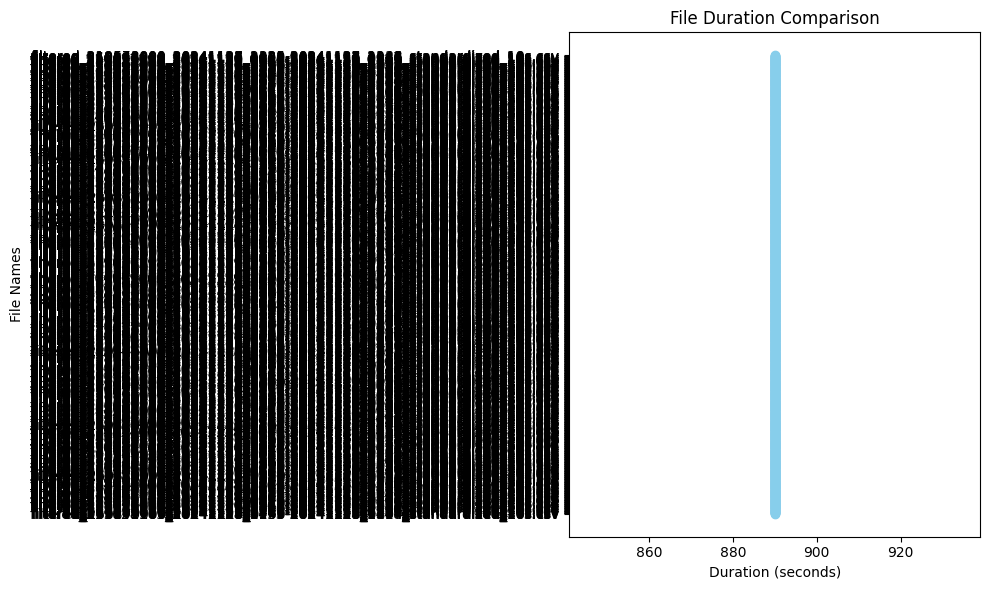

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Lists to store file names and their durations
file_names = []
durations = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Append the file name and duration
        file_names.append(filename)
        durations.append(time_diff.total_seconds())  # Convert to seconds for easy comparison

# Scatter plot with durations on the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(durations, file_names, color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('File Names')
plt.title('File Duration Comparison')

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
import os
import pandas as pd

def check_underway_sog(folder, sog_threshold):
    # Step 1: Get all CSV files in the specified folder
    csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

    for csv_file in csv_files:
        file_path = os.path.join(folder, csv_file)
        try:
            # Step 2: Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Step 3: Check if the navigational status is "Underway using engine" and SOG is above threshold
            if 'Navigational status' in df.columns and 'SOG' in df.columns:
                # Assuming there is only one row (vessel) per file, we directly check the condition
                navigational_status = df['Navigational status'].iloc[0]  # First row, first column value
                sog = df['SOG'].iloc[0]  # First row, first column value

                if navigational_status == 'Underway using engine' and sog > sog_threshold:
                    print(f"File {csv_file}: Vessel is 'Underway using engine' with SOG above {sog_threshold}")
            else:
                print(f"File {csv_file}: Missing required columns ('Navigational status' or 'SOG').")

        except Exception as e:
            print(f"Failed to process {csv_file}: {e}")

# Example usage:
folder = 'time_sets_st_shortened'  # Replace with your folder path
sog_threshold = 5.0  # Example threshold for SOG (e.g., 5 knots)

check_underway_sog(folder, sog_threshold)
